In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
                             roc_curve, auc, roc_auc_score, classification_report)
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Task 1. Bias-variance trade-off

Demonstrate bias-variance trade-off for `DecisionTreeRegressor` when changing tree depth. Build a regression model of the function from one independent variable, presented in the cell below, using the `plot_regression_predictions` function (you can change it somehow if you want). Try different values ​​of tree depth, at what value do you think the model is optimal, at what value does the variance become too large?

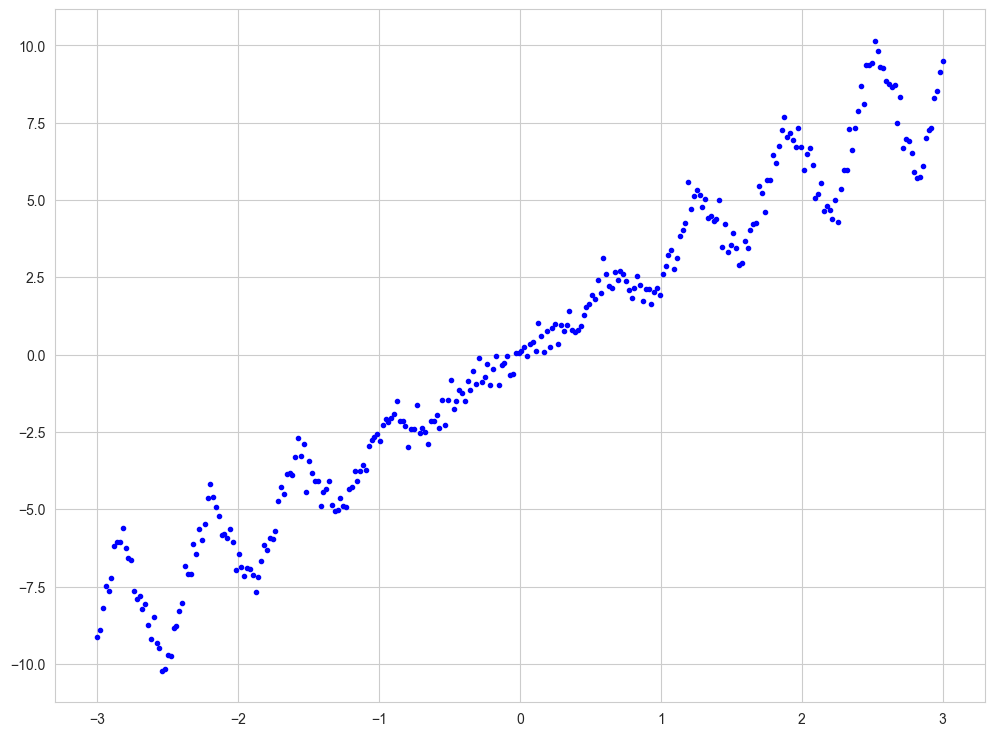

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Function for drawing predictions of decision trees in case of regression
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Draw how the tree's predictions change as the maximum depth increases.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

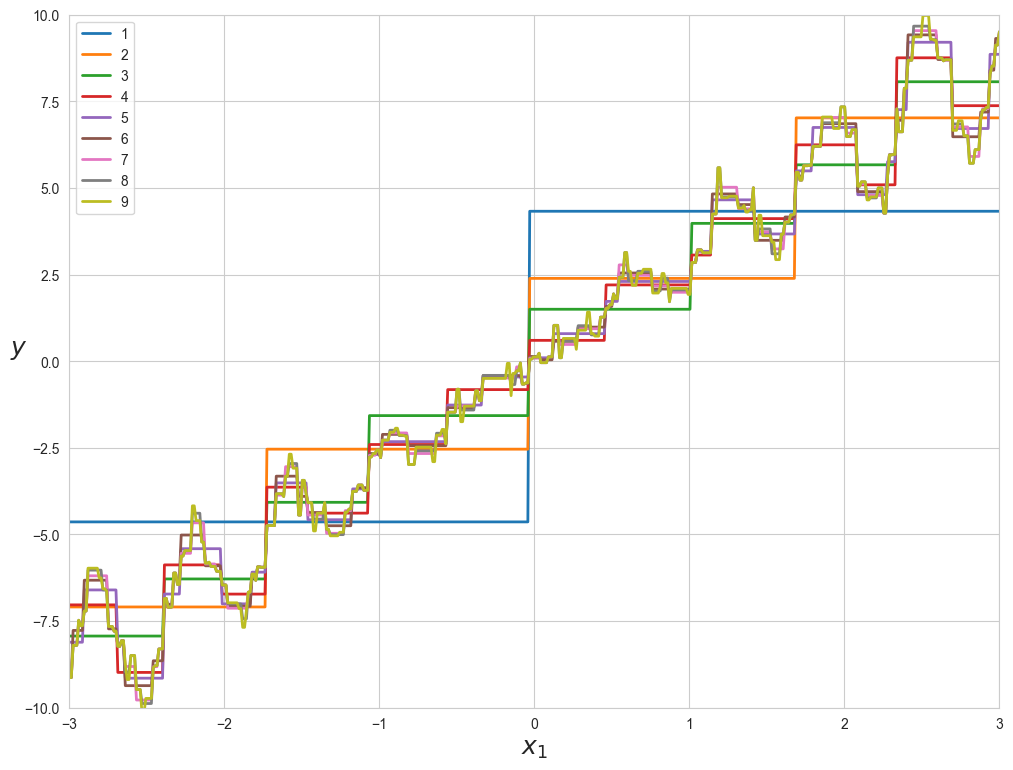

In [6]:
depth_range = range(1, 10)
for i in depth_range:
    model = DecisionTreeRegressor(max_depth=i)
    model.fit(X_train, y_train)
    plot_regression_predictions(model, X_test, y_test)
plt.legend(depth_range)

**In this case above max_depth=6 predictions are almost indistingushible. let's look how well it's correlated with test data for depth equal 3, 5 and 7**

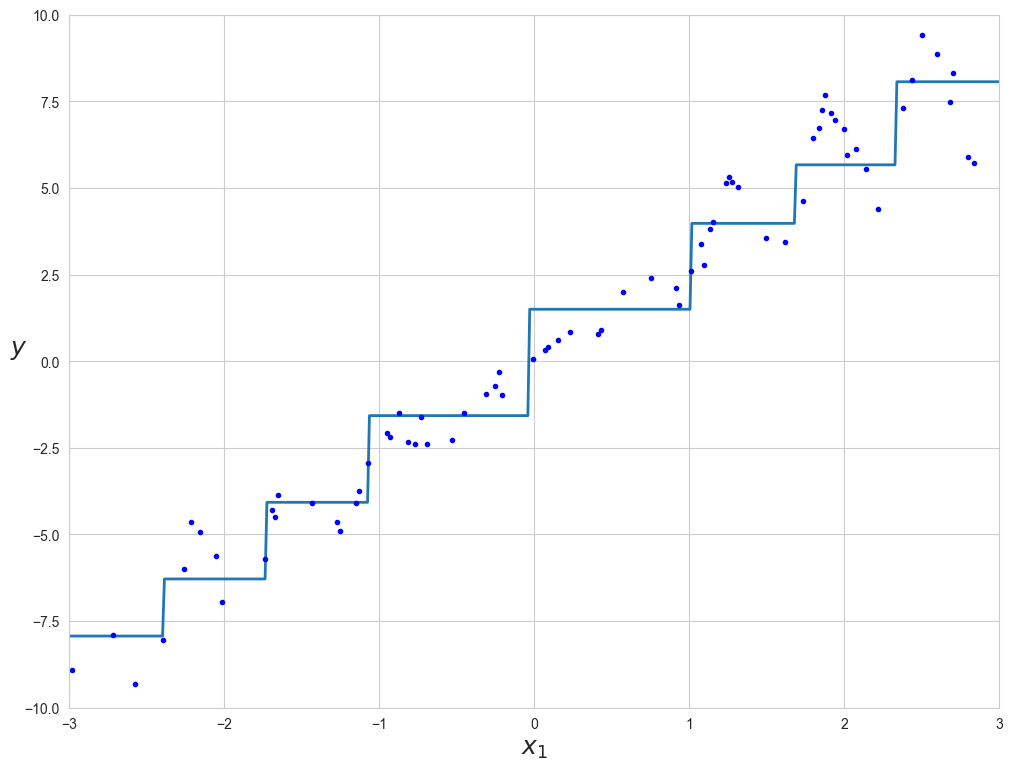

In [7]:
model = DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)
plot_regression_predictions(model, X_test, y_test)
plt.plot(X_test.reshape(-1), y_test.reshape(-1), "b.")

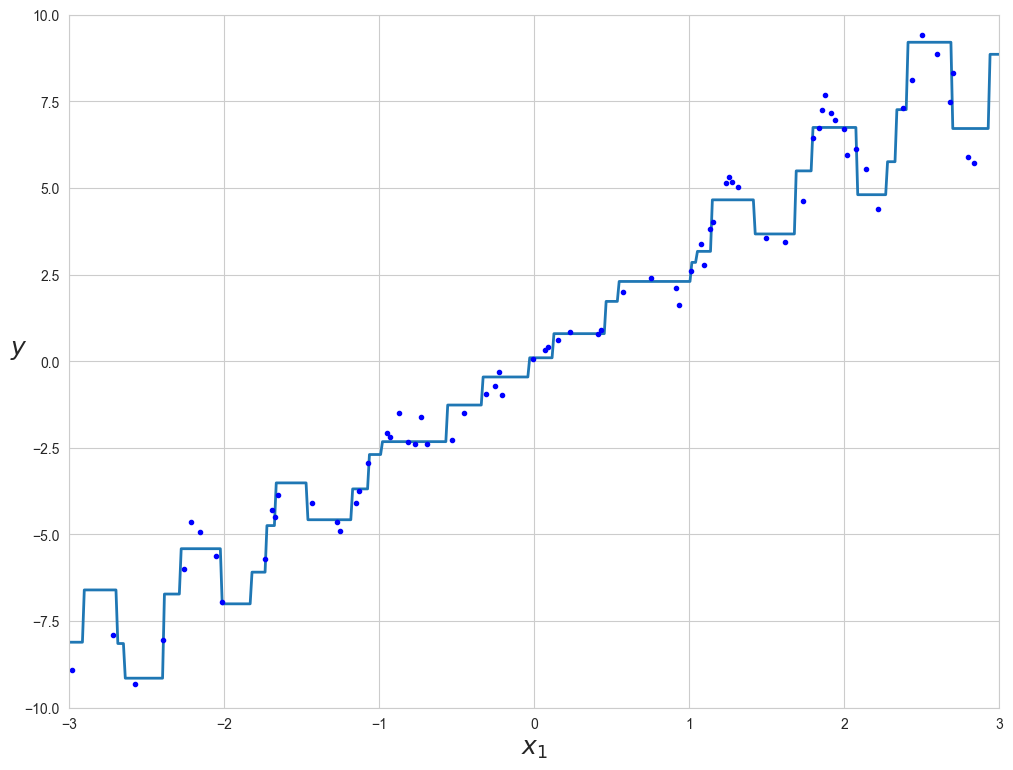

In [8]:
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)
plot_regression_predictions(model, X_test, y_test)
plt.plot(X_test.reshape(-1), y_test.reshape(-1), "b.")

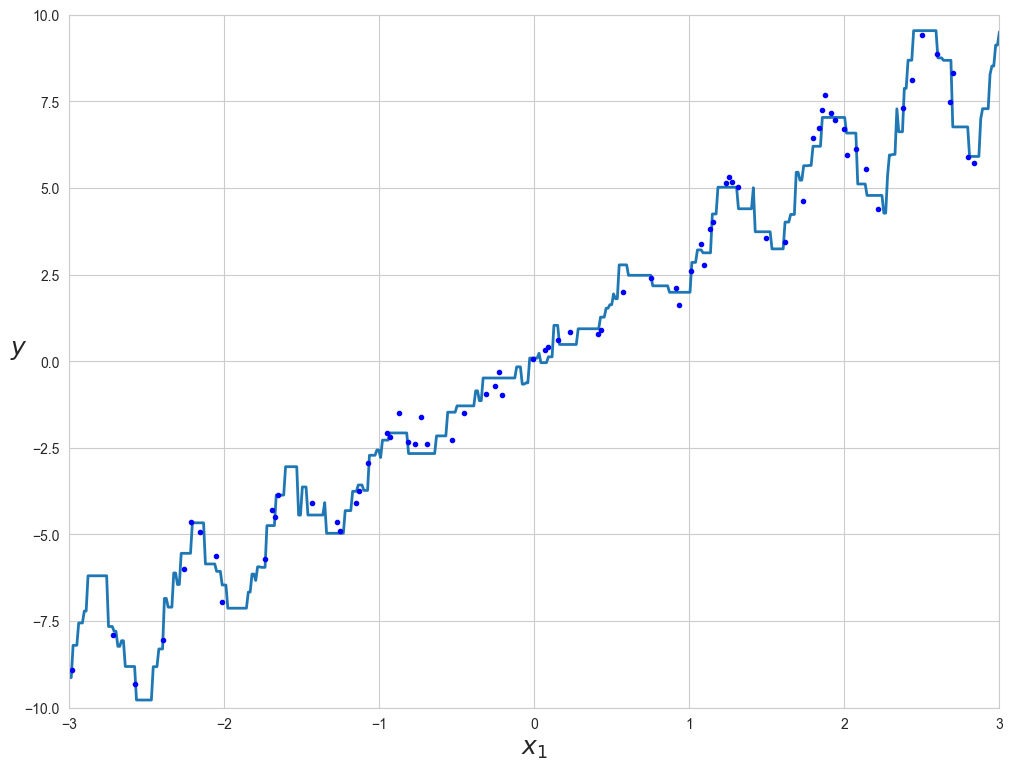

In [9]:
model = DecisionTreeRegressor(max_depth=7)
model.fit(X_train, y_train)
plot_regression_predictions(model, X_test, y_test)
plt.plot(X_test.reshape(-1), y_test.reshape(-1), "b.")

### Task 2. Random forest

Now let's do a little preparation to implement our own random forest, and then we'll implement it.

#### Task 2. 1. Simple ensemble


Let's imagine that we have 101 classifiers. Everyone can correctly predict the class of an object with probability `p` (equal for all models). We will make predictions based on the majority vote. Plot the probability of correctly classifying an object as a function of the `p` value. You may find the following formula helpful:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [97]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##


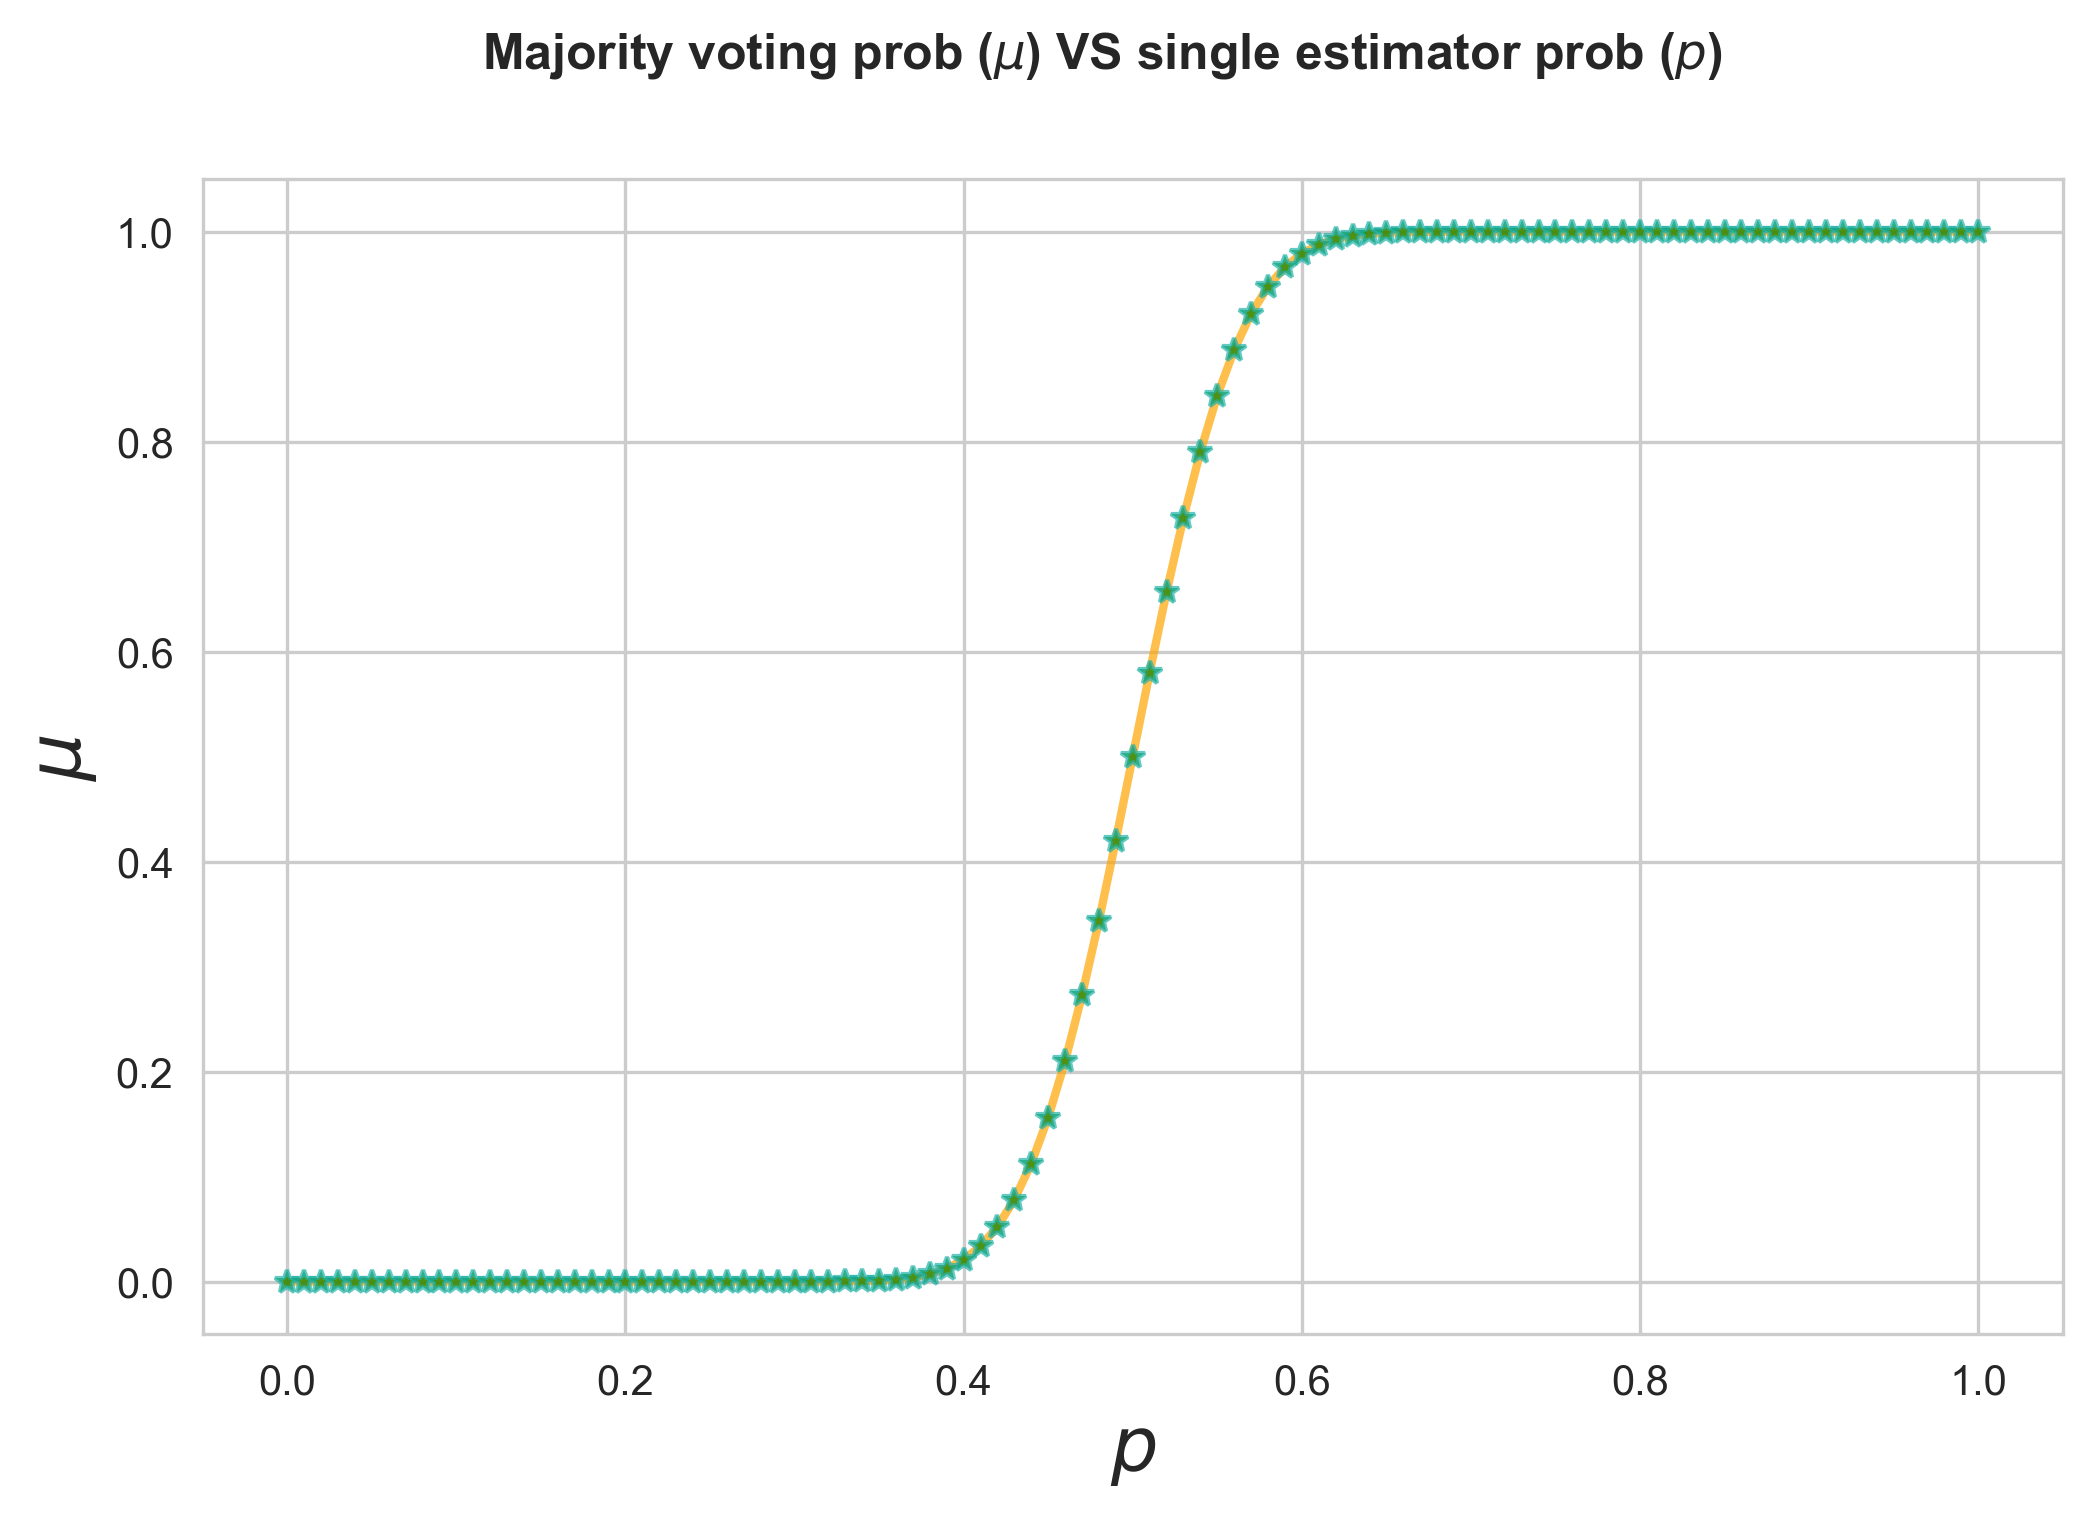

In [11]:
p_values = np.arange(0, 1.01, 0.01)
max_i = 101
min_i = 51
i_ = list(range(min_i, max_i+1))
mu = list(sum(math.comb(max_i, i) * p**i * (1 - p)**(max_i - i) for i in i_) for p in p_values)

fig, ax = plt.subplots(figsize=(8,5), dpi=300)
ax.plot(p_values, mu, linewidth=2, color="orange", alpha=0.7, marker="*", markersize=6, mec="lightseagreen", mfc="green")
ax.set_xlabel("$p$", fontsize=18, fontweight="bold")
ax.set_ylabel("$\mu$", fontsize=18, fontweight="bold")
fig.suptitle("Majority voting prob ($\mu$) VS single estimator prob ($p$)", 
             fontsize=12, fontweight="bold");

Now let's look at another situation. We have a fixed probability that the model correctly classifies the object `p = 0.65`. Plot the dependence of the probability of correctly classifying an object on the number of models in the ensemble.

In [12]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

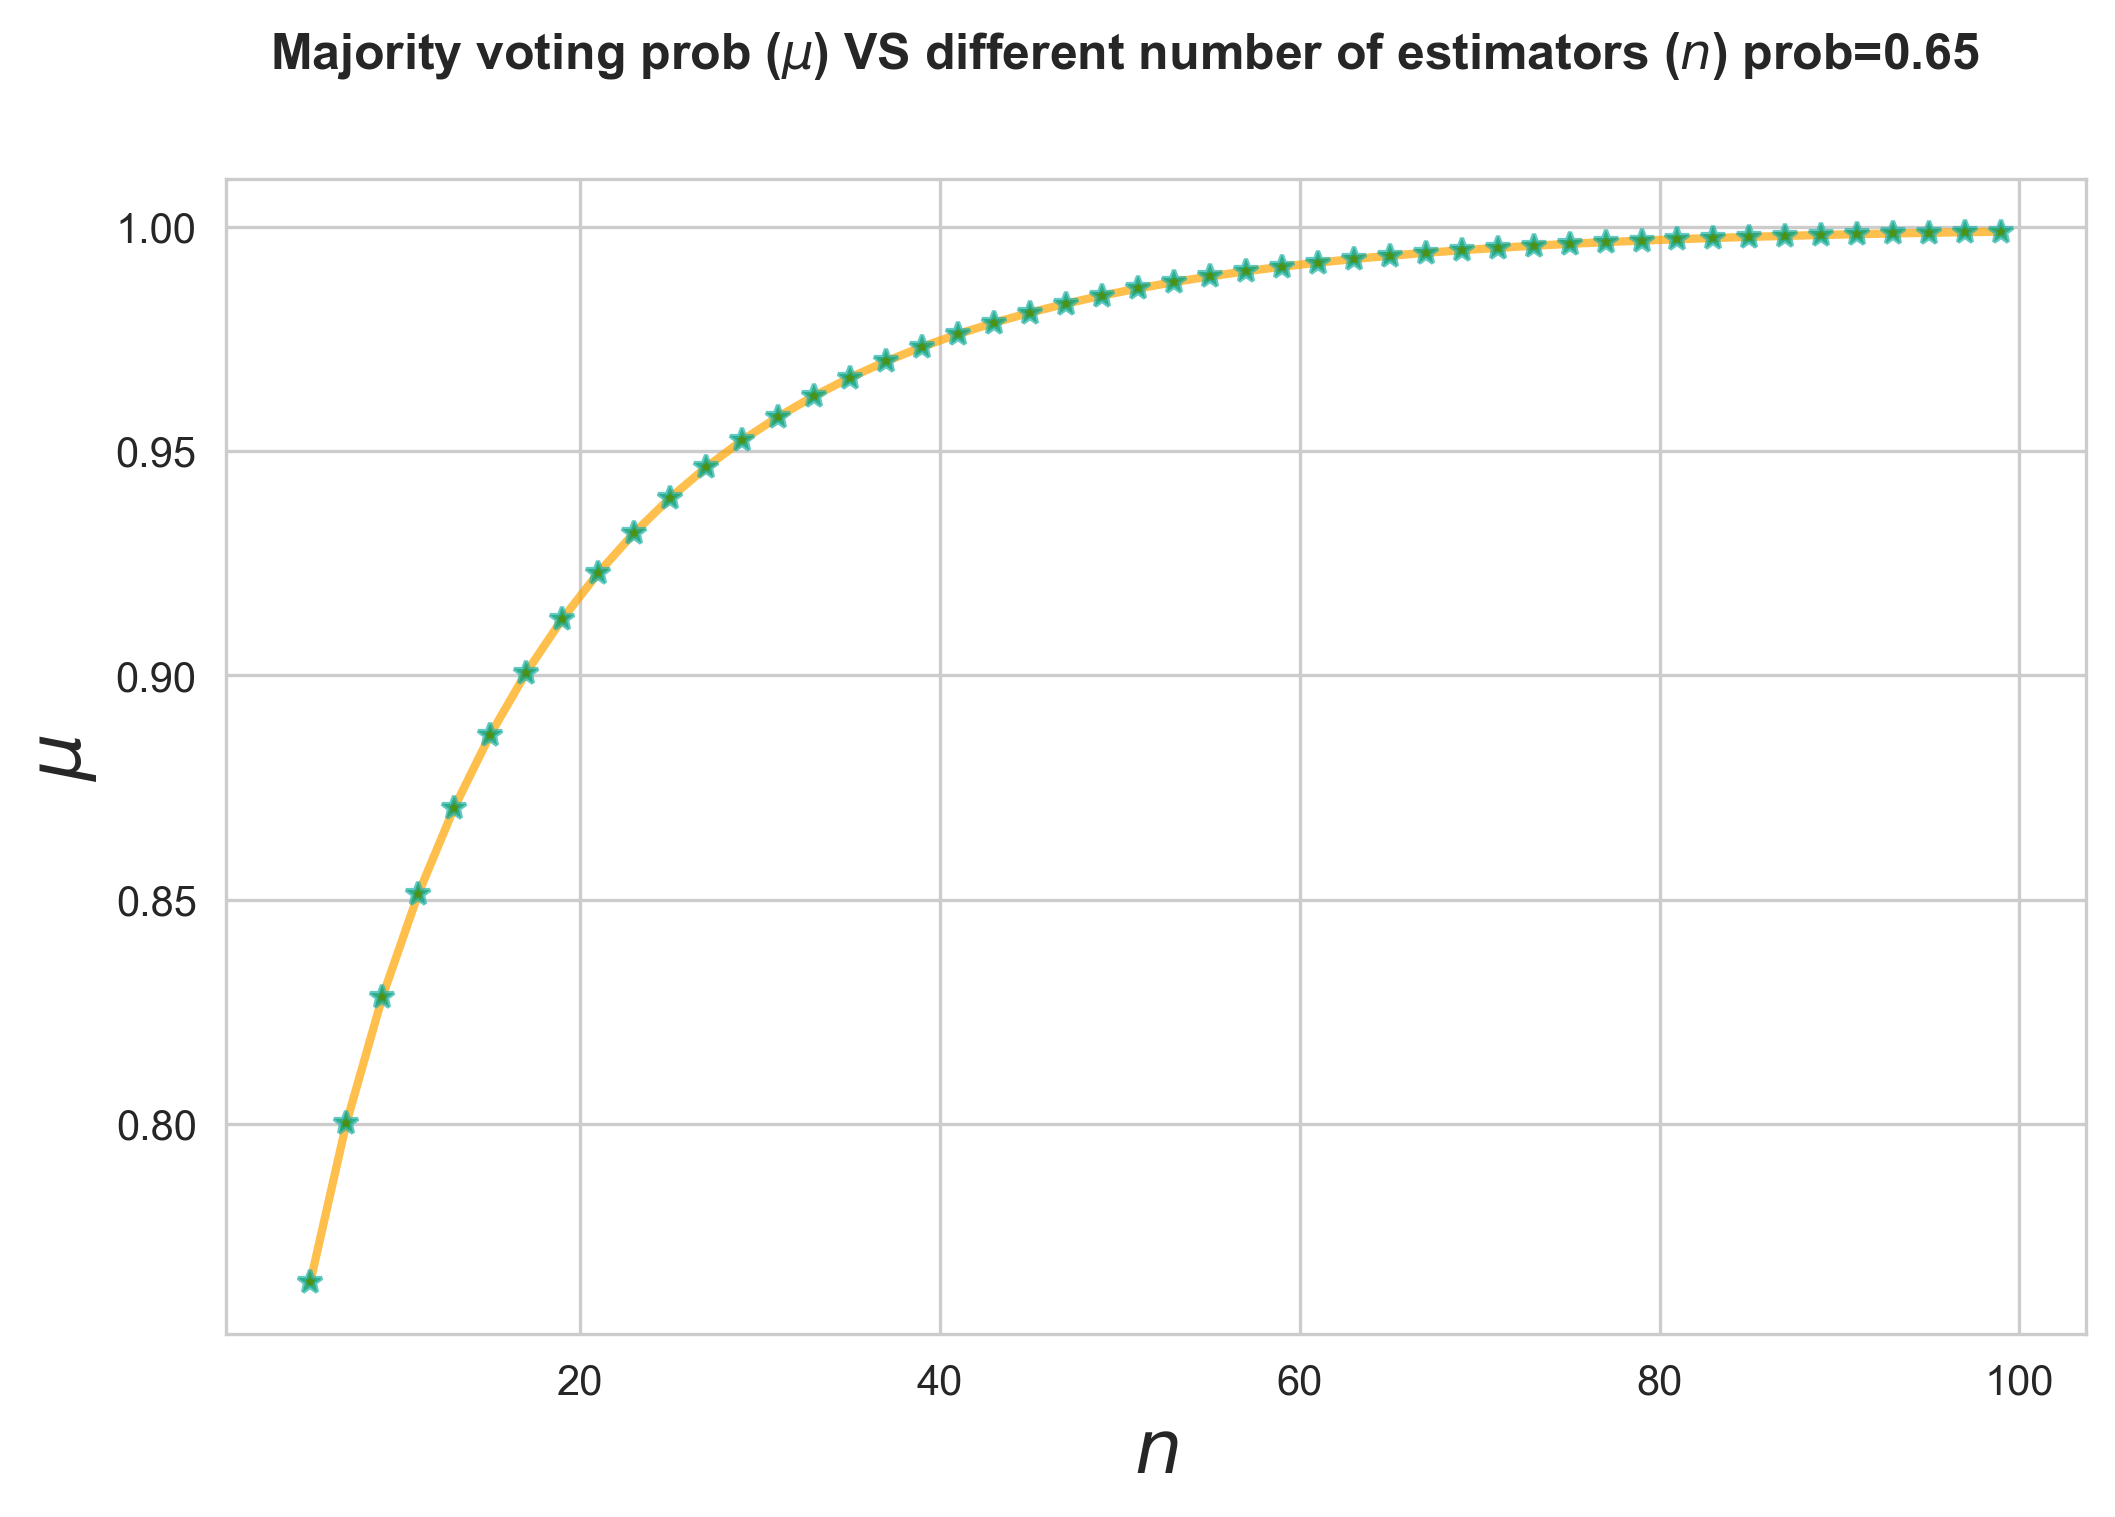

In [13]:
p = 0.65
max_is =  np.arange(5,101, 2)
mu = list(sum(math.comb(max_i, i) * p**i * (1 - p)**(max_i - i) for i in range(max_i//2+1, max_i+1)) for max_i in max_is)
fig, ax = plt.subplots(figsize=(8,5), dpi=300)
ax.plot(max_is, mu, linewidth=2, color="orange", alpha=0.7, marker="*", markersize=6, mec="lightseagreen", mfc="green")
ax.set_xlabel("$n$", fontsize=18, fontweight="bold")
ax.set_ylabel("$\mu$", fontsize=18, fontweight="bold")
fig.suptitle("Majority voting prob ($\mu$) VS different number of estimators ($n$) prob=0.65 ", 
             fontsize=12, fontweight="bold");

Describe your observations:

* WOW! With a given probability around 0.6 for single estimator we can reach probability of correct answer for 100 estimators!
* WOW! The more estimators we have, the higher is probability of correct answer.

#### Task 2. 2. Implementation of sumple RF


Implement your own `RandomForestClassifierCustom` class using `DecisionTreeClassifier` from `sklearn` as a base model.

A short description:
- Use the code below
- In the `fit` method in a loop (`i` from 0 to `n_estimators-1`):
     * Fix the random number generator as follows np.random.seed(`random_state + i`). The idea is that at each iteration we will have a new value for the random number generator, which will add more "randomness", but at the same time we will be able to have reproducible results
     * Then select `max_features` features **without replacement**, save the list of selected features (their indices) in `self.feat_ids_by_tree`
     * Also create a pseudo-sample using bootstrap (selection **with replacement**) from the training data. The `np.random.choice` function and its `replace` argument can help
     * Train a decision tree with the parameters specified in the class constructor `max_depth`, `max_features` and `random_state` on the resulting pseudo-sample.
- The `fit` method should return the current instance of the `RandomForestClassifierCustom` class, that is `self` (everything is grown-up, like in `sklearn`)
- In the `predict_proba` method we must loop through all the trees. For each prediction, we will need to take only those features that the original tree learned from, which is why we stored this information in the `self.feat_ids_by_tree` attribute. This method should return predicted probabilities (can be done in two ways: for each tree, predict the value using the `predict_proba` method and then average these probabilities, or, for example, use the `predict` method and also calculate the average.

In [14]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.trees = []
        self.feat_ids_by_tree = []
        self.classes_ = sorted(np.unique(y))
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            self.feat_ids_by_tree.append(np.random.choice(X.shape[1], size=self.max_features, replace=False))
            sub_idx = np.random.choice(X.shape[0], size=X.shape[0], replace=True).reshape(X.shape[0], 1)
            sub_X = X[sub_idx, self.feat_ids_by_tree[i]]
            sub_y = y[sub_idx]
            tree = DecisionTreeClassifier(max_depth=self.max_depth,
                                          max_features=self.max_features,
                                          random_state=self.random_state+i)
            tree.fit(sub_X, sub_y)
            self.trees.append(tree)
        return self


    def predict_proba(self, X):
        votes = []
        for i, tree in enumerate(self.trees):
            # строка ниже чинит работу, но ломает рисовалку
            # vote = tree.predict_proba(X[:, self.feat_ids_by_tree[i]].reshape(-1, 1))
            vote = tree.predict_proba(X[:, self.feat_ids_by_tree[i]])
            votes.append(vote)
        return np.mean(votes, axis=0)

    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions

Let's test our implementation on artificial data. Visualize the dividing boundary that your model draws using the `plot_decision_boundary` function (see examples in the lecture).

In [15]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

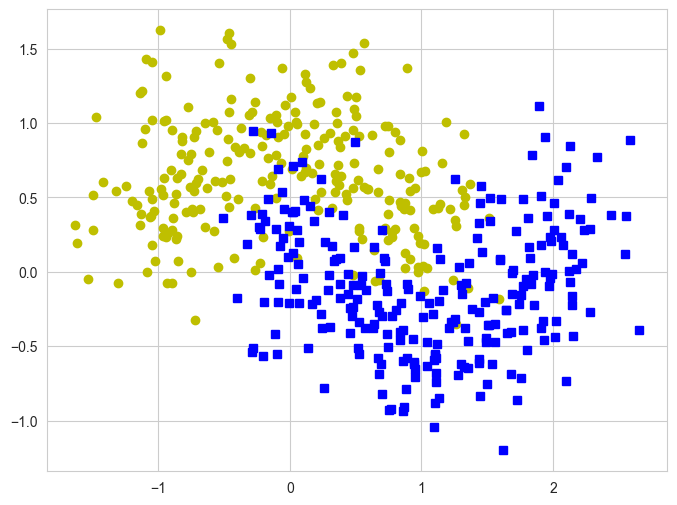

In [16]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

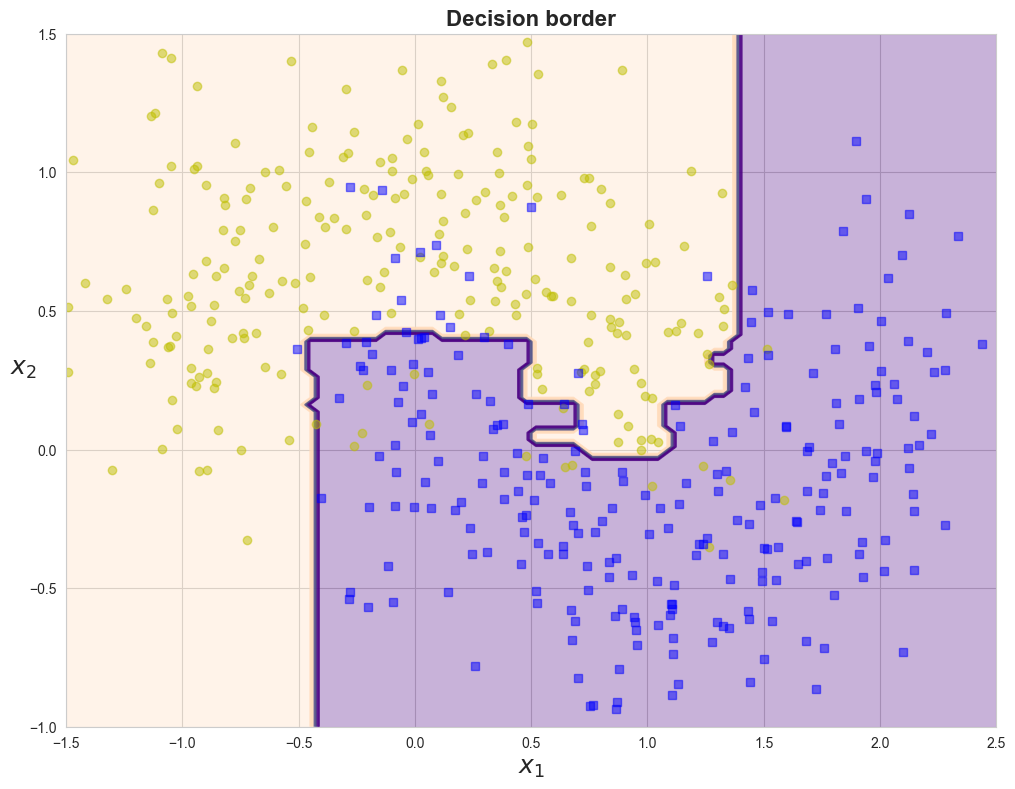

In [17]:
model = RandomForestClassifierCustom(max_depth=5, max_features=2,
                                     random_state=SEED)
model.fit(X, y)
plot_decision_boundary(model, X, y)
plt.title("Decision border", fontsize=16, fontweight="bold");

Select the best hyperparameters at which the dividing boundary will, in your opinion, be optimal in terms of bias-variance. You can also connect some metrics to select the best model.

In [18]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

parameters = {"n_estimators": list(range(11, 200, 5)),
              "max_depth" : list(range(1, 26)),
              "max_features": [1, 2], 
              "random_state": [SEED]}

cv_model = GridSearchCV(estimator=RandomForestClassifierCustom(),
                            param_grid=parameters,
                            scoring="accuracy",
                            n_jobs=-1)

cv_model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifierCustom(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25],
                         'max_features': [1, 2],
                         'n_estimators': [11, 16, 21, 26, 31, 36, 41, 46, 51,
                                          56, 61, 66, 71, 76, 81, 86, 91, 96,
                                          101, 106, 111, 116, 121, 126, 131,
                                          136, 141, 146, 151, 156, ...],
                         'random_state': [111]},
             scoring='accuracy')

In [20]:
# print(cv_model.best_estimator_)
print(cv_model.best_score_)

0.9173333333333333


precision_score: 0.9166666666666666
recall_score: 0.9166666666666666
f1_score: 0.9166666666666666
accuracy_score: 0.92


Text(0.5, 1.0, 'Classification with the best hyperparameters')

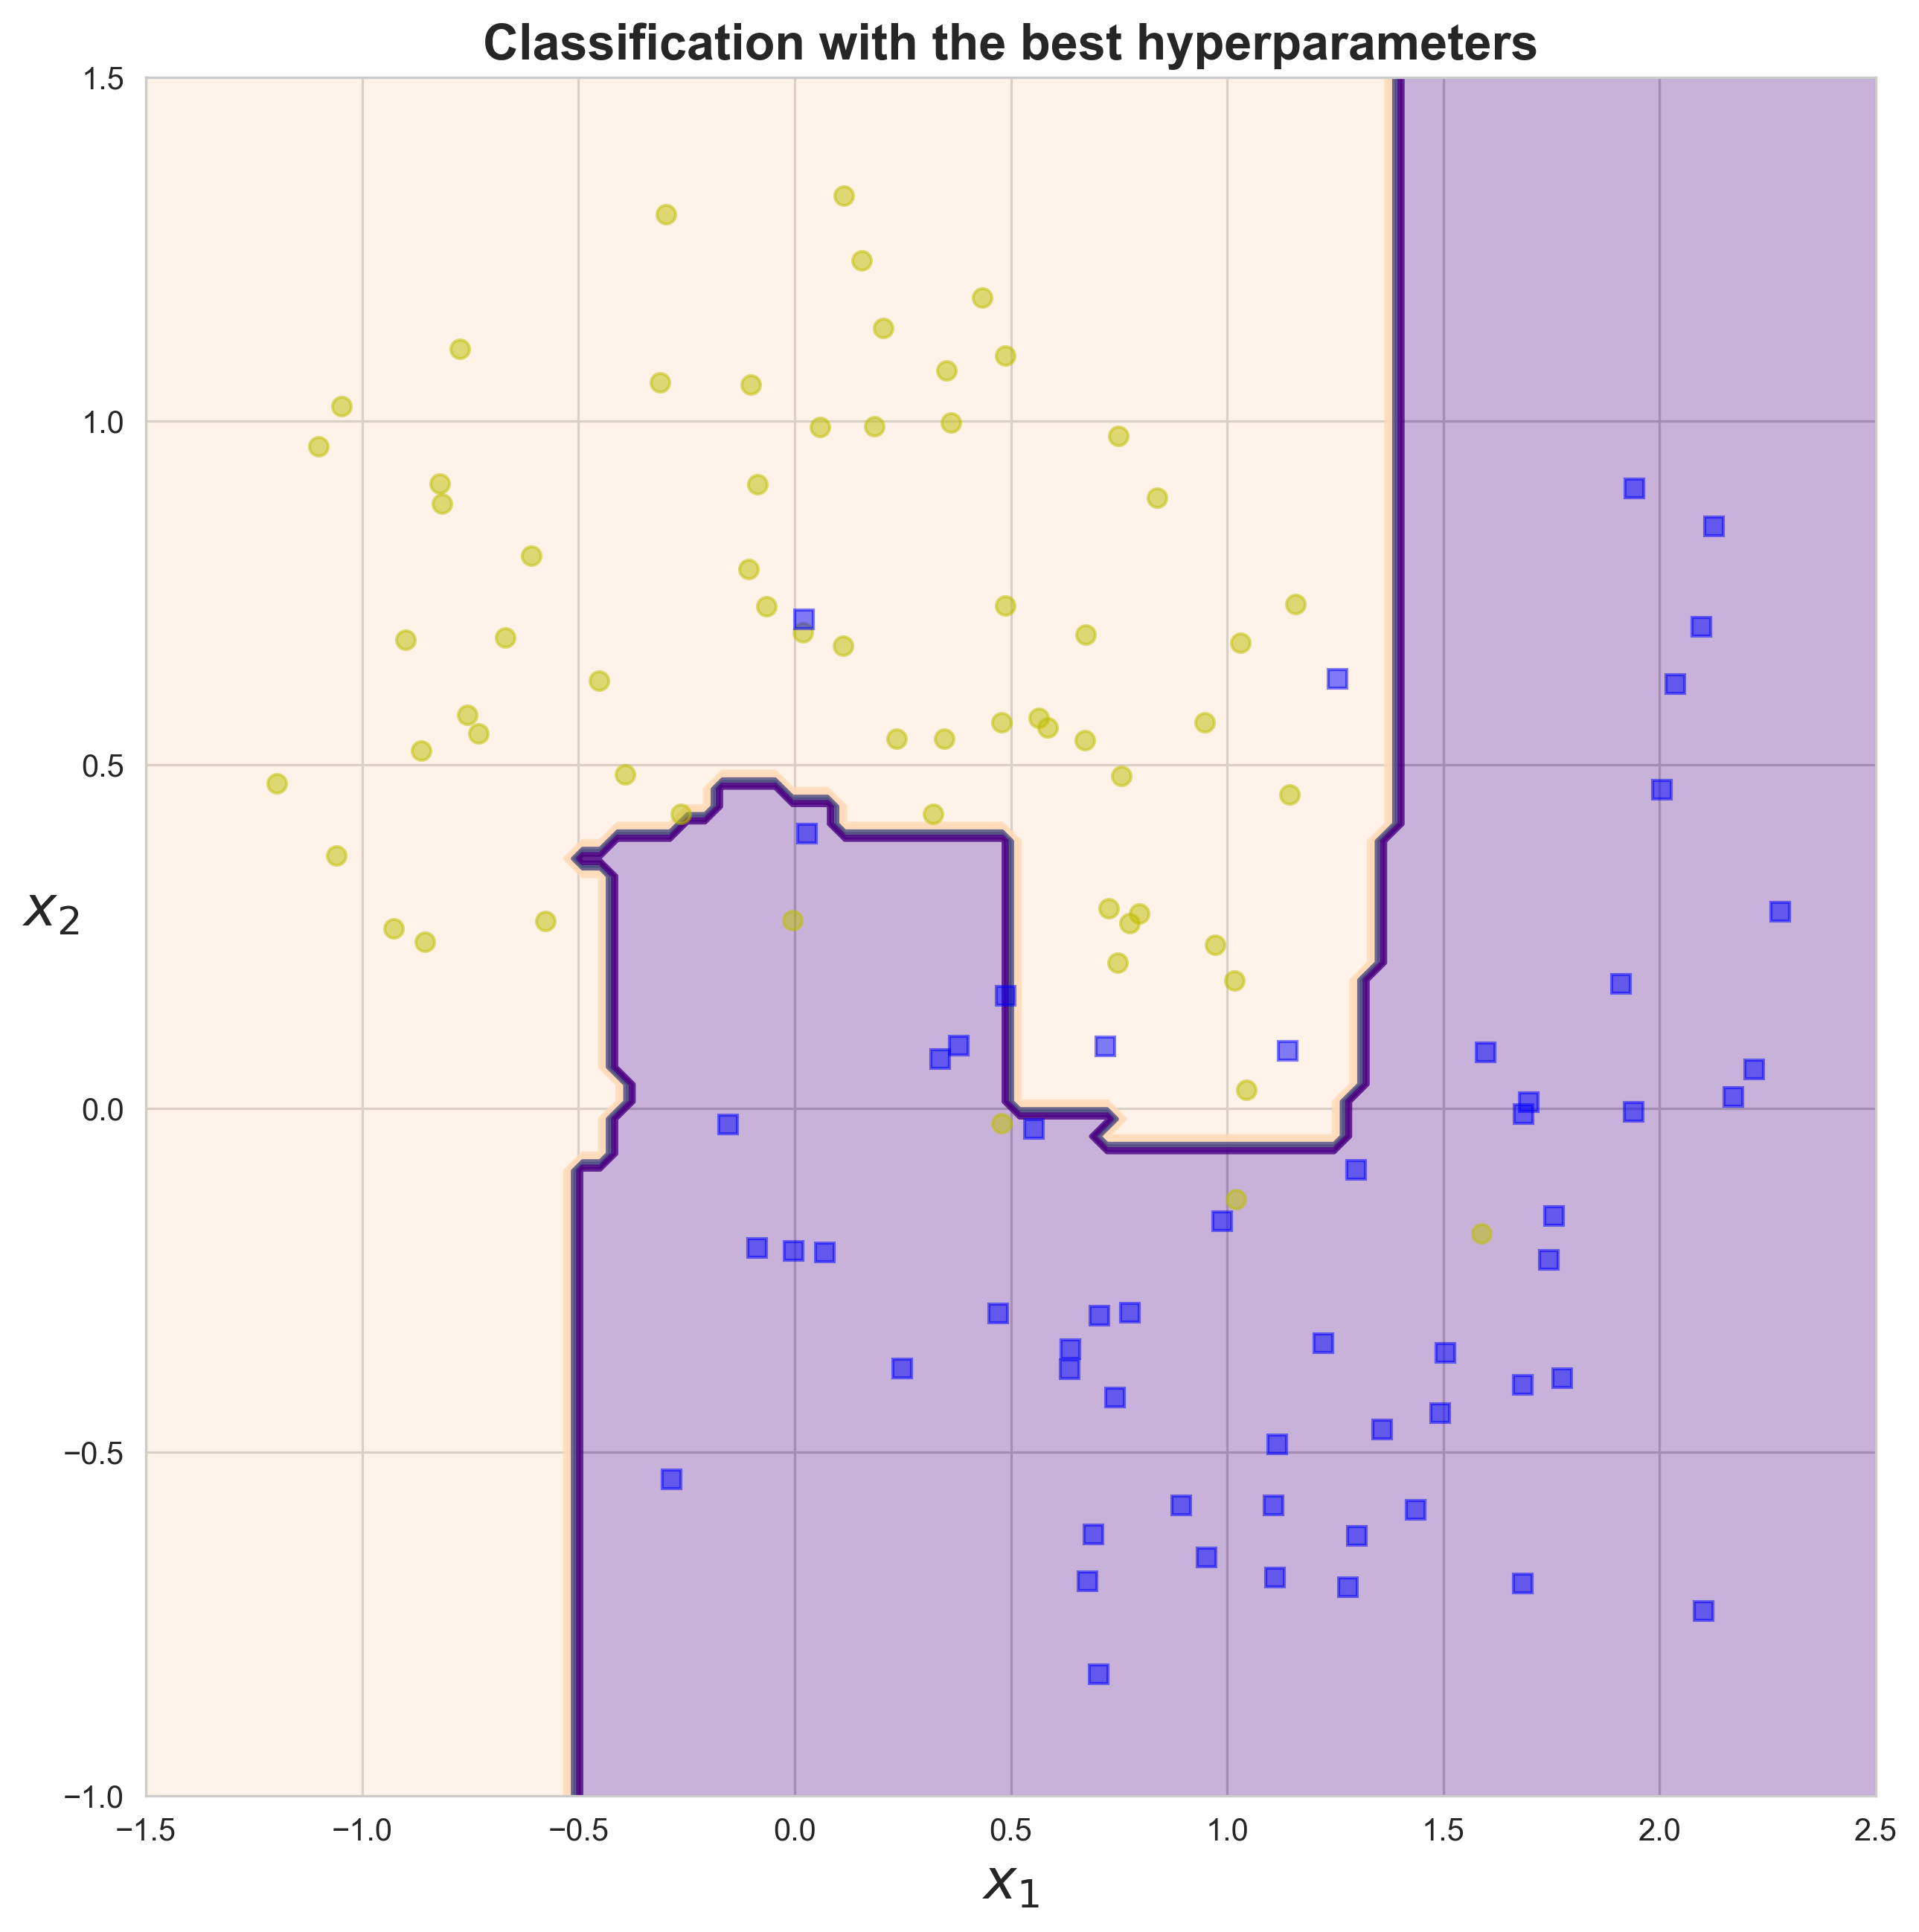

In [21]:
cv_model = RandomForestClassifierCustom(n_estimators=186, max_depth=5, max_features=2, random_state=SEED)
cv_model.fit(X_train, y_train)
y_pred = cv_model.predict(X_test)

metrics=[precision_score, recall_score, f1_score, accuracy_score]
for metric in metrics:
    print(f'{metric.__name__}: {metric(y_test, y_pred)}')

fig, ax = plt.subplots(figsize=(10,10), dpi=300)
plot_decision_boundary(cv_model, X_test, y_test)
plt.title("Classification with the best hyperparameters", fontsize=16, fontweight='bold')

#### Task 2. 3. Correlation of basic models

As we learned in lecture, for bagging to work well, the predictions of our models should not be highly correlated. To achieve this, various approaches are used in random forests, including RSM. Let's see how the `max_features` parameter affects the correlation of the base models in the random forest from `sklearn`. As an example, we will use the `breast_cancer` dataset. To calculate correlations, use the `base_model_pair_correlation` function below. For each model, you will get a set of values (pairwise correlations of all trees), then you can depict them in the form of boxplots, just as we drew the distribution of metrics in lecture.

In [22]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [23]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [25]:
list(range(1, X.shape[1], 2))

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [26]:
max_features = list(range(1, X.shape[1], 2))
max_features_dict = {}

for n_features in max_features:
    model = RandomForestClassifier(max_features=n_features)
    model.fit(X_train, y_train)
    max_features_dict[n_features] = base_model_pair_correlation(model, X_test)

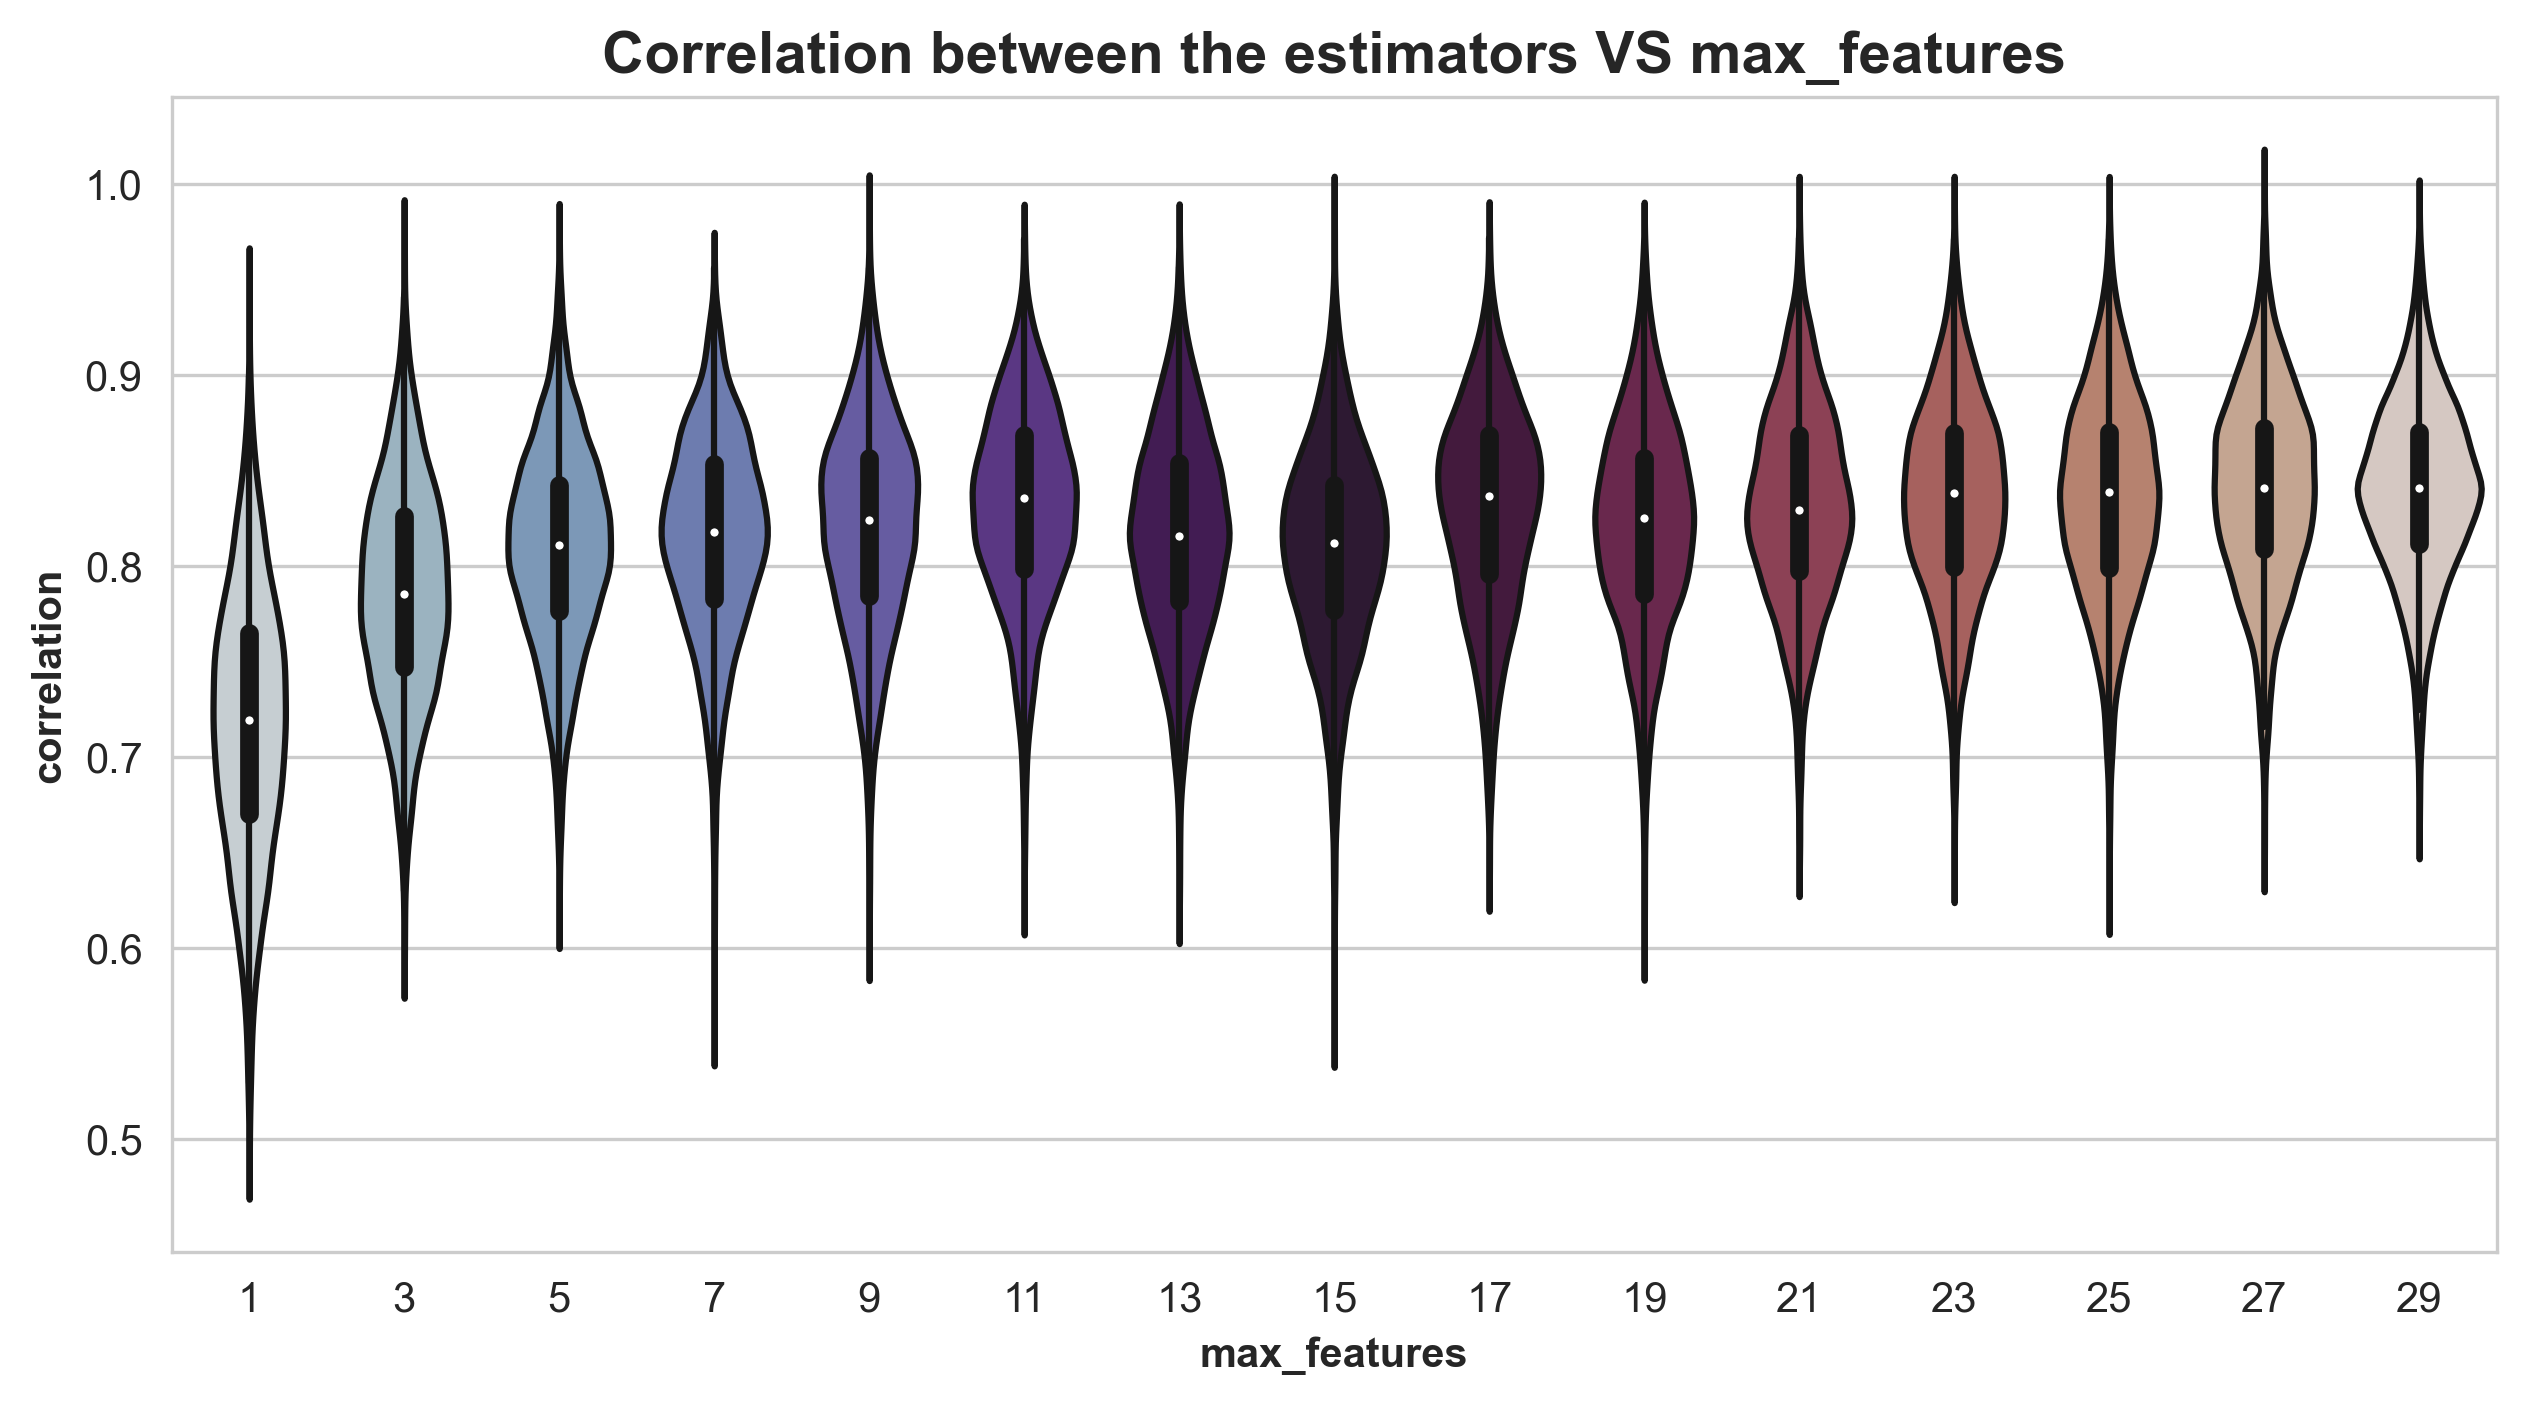

In [27]:
max_features_df = pd.DataFrame(max_features_dict)

fig, ax = plt.subplots(figsize=(10,5), dpi=300)
sns.violinplot(data=max_features_df, palette="twilight", ax=ax)
ax.set_title("Correlation between the estimators VS max_features", 
             fontsize=14, fontweight="bold")
ax.set_xlabel("max_features", fontweight="bold")
ax.set_ylabel("correlation", fontweight="bold");

Now let's see how the `max_depth` parameter affects this:

In [28]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [29]:
max_depth = [1, 2, 5, 10, 15, 25, 50, 100, 200]
max_depth_dict = {}

for md in max_depth:
    model = RandomForestClassifier(max_depth=md)
    model.fit(X_train, y_train)
    max_depth_dict[md] = base_model_pair_correlation(model, X_test)

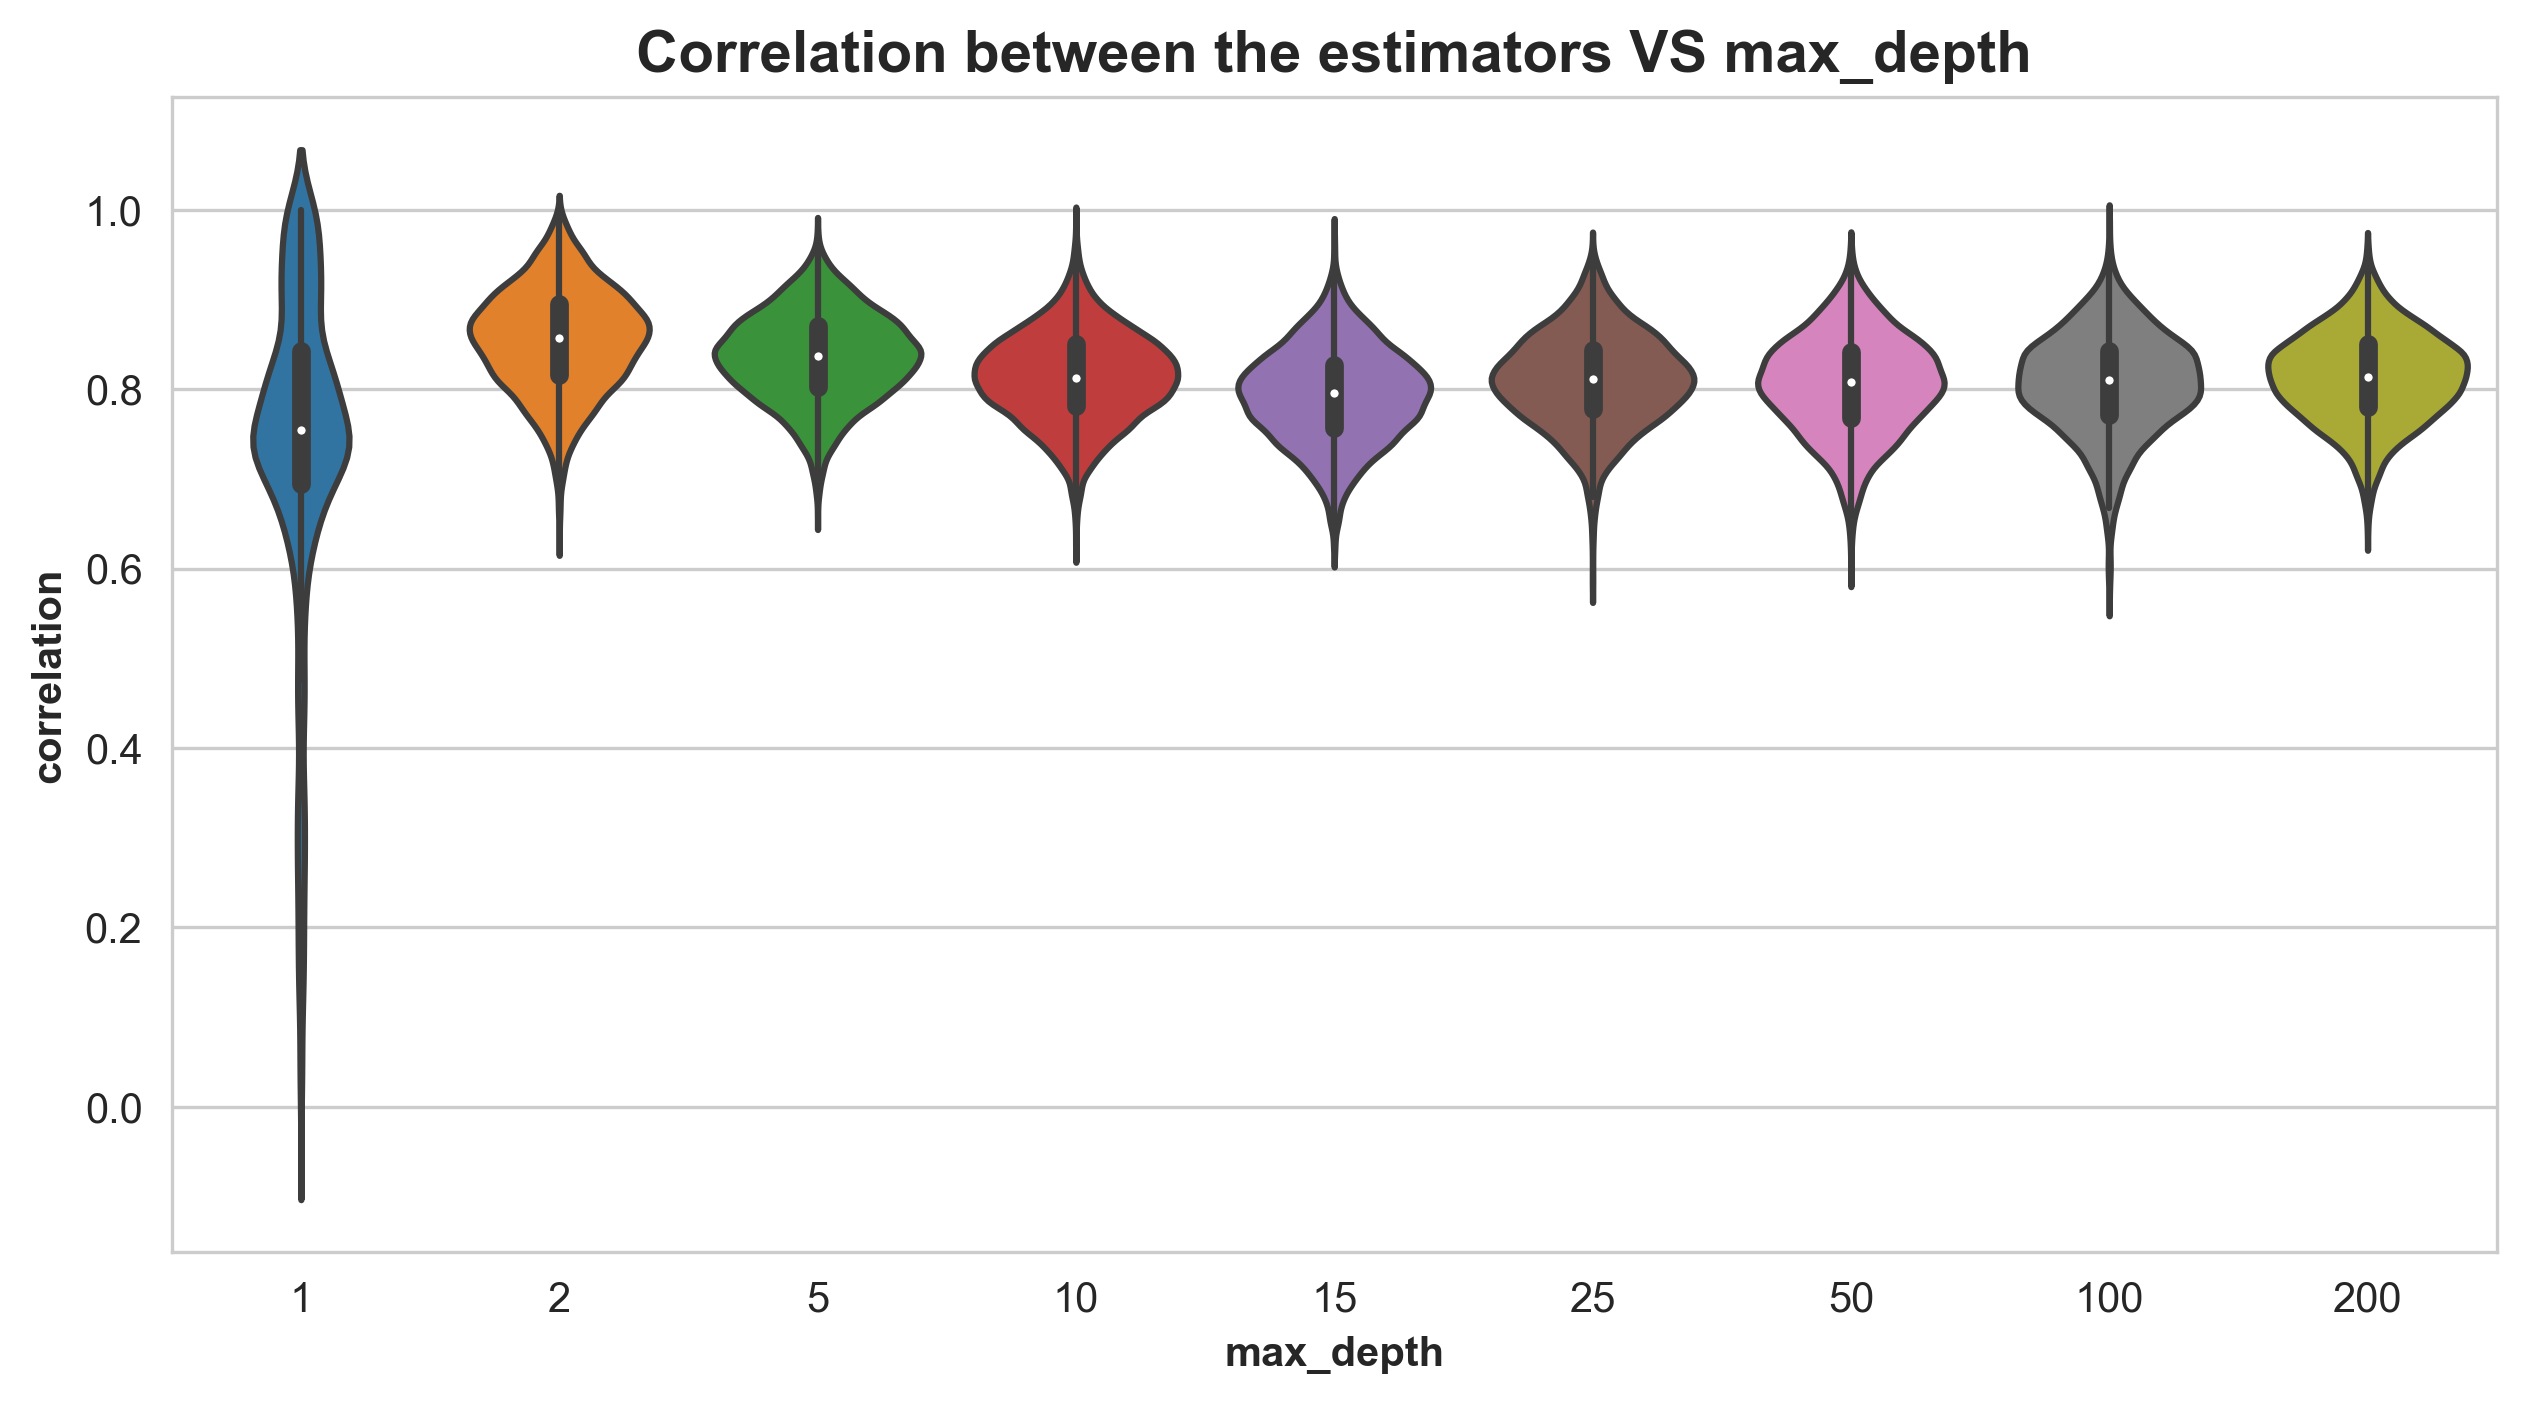

In [30]:
max_depth_df = pd.DataFrame(max_depth_dict)

fig, ax = plt.subplots(figsize=(10,5), dpi=300)
sns.violinplot(data=max_depth_df, ax=ax)
ax.set_title("Correlation between the estimators VS max_depth", 
             fontsize=14, fontweight="bold")
ax.set_xlabel("max_depth", fontweight="bold")
ax.set_ylabel("correlation", fontweight="bold");

Describe your observations:

* The larger `the max_features` parameter, the stronger is the correlation of estimators, with a plateau over 9;
* It looks like with `max_depth`= 1 correlation is the lowest. Maximum is at parameter equal 2. Beyond this correlation is reducing reaching plateau at some point. 1


### Task 3. Building a large ensemble

   



In this task, you need to diagnose heart disease in people using [medical indicators](https://www.kaggle.com/ronitf/heart-disease-uci).

In [31]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [32]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Train a variety of classifiers below, as well as an ensemble of `VotingClassifier` from `sklearn.ensemble` combining these classifiers using hard or soft voting (parameter `voting = `'hard'` or `'soft'` respectively). Evaluate the quality of models using cross-validation on the training set using the `cross_val_score` function and the `f1` metric. We didn’t go through some of the models from here, you can read more about them, but in principle, for the task it is not very important to know the principles of their operation (but, if you have time, then read it, it’s interesting).

In [40]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED, verbose=-1)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED,
                                  verbose=-1)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Various warnings may appear here when training boosters, don't worry, everything is fine, they're just usually very talkative)

In [41]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8463991769547325
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8445754787218203
VotingClassifier: 0.8503633581946834


You may notice that the ensemble shows good, but not the best prediction quality, let's try to improve it. As you know, ensembles work best when the models included in them are not correlated with each other. Determine the correlation of the predictions of the base models in the ensemble on a test data set, and remove from the ensemble those models whose predictions are more strongly correlated with the others. Use the `base_model_pair_correlation_for_voting_clf` function. **Spoiler**: While it’s far from a fact that if you remove two models with a correlation of 0.95, everything will become much better, but here everything will be a little more complicated. To achieve maximum quality, you may need a long search of different combinations of models. The best speed that I managed to achieve is 0.915, but it was obtained by a very strange combination of algorithms, and also by simply trying out all the options)

In [80]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        # corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))
        corrs.append((est1.__class__.__name__, est2.__class__.__name__, pearsonr(ypred_t1, ypred_t2)[0]))
        


    return corrs

In [81]:
ensemble = VotingClassifier(estimators=base_models, voting='soft')
ensemble.fit(X_train, y_train)
corrs = base_model_pair_correlation_for_voting_clf(ensemble, X)

In [91]:
corr_df = pd.DataFrame(corrs)
corr_df = corr_df[corr_df[2]>=0.95].sort_values(by=2, ascending=False)
corr_df

0                     1         2
64          LGBMClassifier         XGBClassifier  0.990632
57      CatBoostClassifier        LGBMClassifier  0.987400
16  RandomForestClassifier    CatBoostClassifier  0.983311
59      CatBoostClassifier         XGBClassifier  0.978323
17  RandomForestClassifier        LGBMClassifier  0.974589
29    ExtraTreesClassifier         XGBClassifier  0.970791
12  RandomForestClassifier  ExtraTreesClassifier  0.968670
26    ExtraTreesClassifier    CatBoostClassifier  0.968586
19  RandomForestClassifier         XGBClassifier  0.968047
27    ExtraTreesClassifier        LGBMClassifier  0.963169
48                     SVC    LogisticRegression  0.962236
60      CatBoostClassifier       XGBRFClassifier  0.957180

In [113]:
models_to_drop = ['CAT', 'XGB_RF']
new_models = [x for x in base_models if x[0] not in models_to_drop]
# new_models
ensemble = VotingClassifier(estimators=new_models, voting='soft')
scores = cross_val_score(ensemble, X_train, y_train, cv=3, scoring="f1")
print(scores.mean())
ensemble.fit(X_train, y_train)
corrs = base_model_pair_correlation_for_voting_clf(ensemble, X)
corr_df = pd.DataFrame(corrs)
corr_df = corr_df[corr_df[2]>=0.95].sort_values(by=2, ascending=False)
corr_df

0.8455110375195781


0                     1         2
46          LGBMClassifier         XGBClassifier  0.990632
14  RandomForestClassifier        LGBMClassifier  0.974589
24    ExtraTreesClassifier         XGBClassifier  0.970791
10  RandomForestClassifier  ExtraTreesClassifier  0.968670
16  RandomForestClassifier         XGBClassifier  0.968047
22    ExtraTreesClassifier        LGBMClassifier  0.963169
38                     SVC    LogisticRegression  0.962236

After many experiments the best solution i've came up with is following:

In [92]:
base_models_new = [("SVC_LIN", svc_lin),
                ('RF', rf),
                ("LGBM", lgbm), 
                ("LR", lr), 
                ("NB", nb)
                ]

voting_soft = VotingClassifier(estimators=base_models_new, voting='soft')
voting_hard = VotingClassifier(estimators=base_models_new, voting='hard')

voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

y_pred_soft = voting_soft.predict(X_test)
y_pred_hard = voting_hard.predict(X_test)

f1_score_soft = f1_score(y_test, y_pred_soft)
f1_score_hard = f1_score(y_test, y_pred_hard)

print(f'Ensemble, voting soft f1_score: {f1_score_soft}')
print(f'Ensemble, voting hard f1_score: {f1_score_hard}')

Ensemble, voting soft f1_score: 0.8712871287128713
Ensemble, voting hard f1_score: 0.8910891089108911


### Task 4. Determining customer churn from telecom

We will predict whether the client will leave us (variable `Churn?`). The data can be downloaded [here](https://www.kaggle.com/venky12347/churn-telecom). This will be a completely adult task, since there is no correct answer to it. You will need to understand the data, prepare it properly for models, and choose the best model.

Minimum task:

Select 2 models &mdash; one random forest and one boost from the ones below:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; random forest by xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; random forest by lightgbm
5. `catboost.CatBoostClassifier`

And try to figure out how to correctly configure hyperparameters for these models. I advise you to google something like the following `how to choose best hyperparameters for lightgbm`. There you will find a bunch of complex and incomprehensible code, but if you understand it and learn how to train non-standard boosts, then in terms of tabular data you will have no equal)

In [8]:
data = pd.read_csv("churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

In [115]:
data.shape

(3333, 21)

**3333 samples, 20 features and target**

In [118]:
data.isna().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [9]:
data = data.rename(columns={"Churn?":"Churn", "Int'l Plan":"Intl Plan"})

**No NAs and 2 columns renamed**

<Axes: >

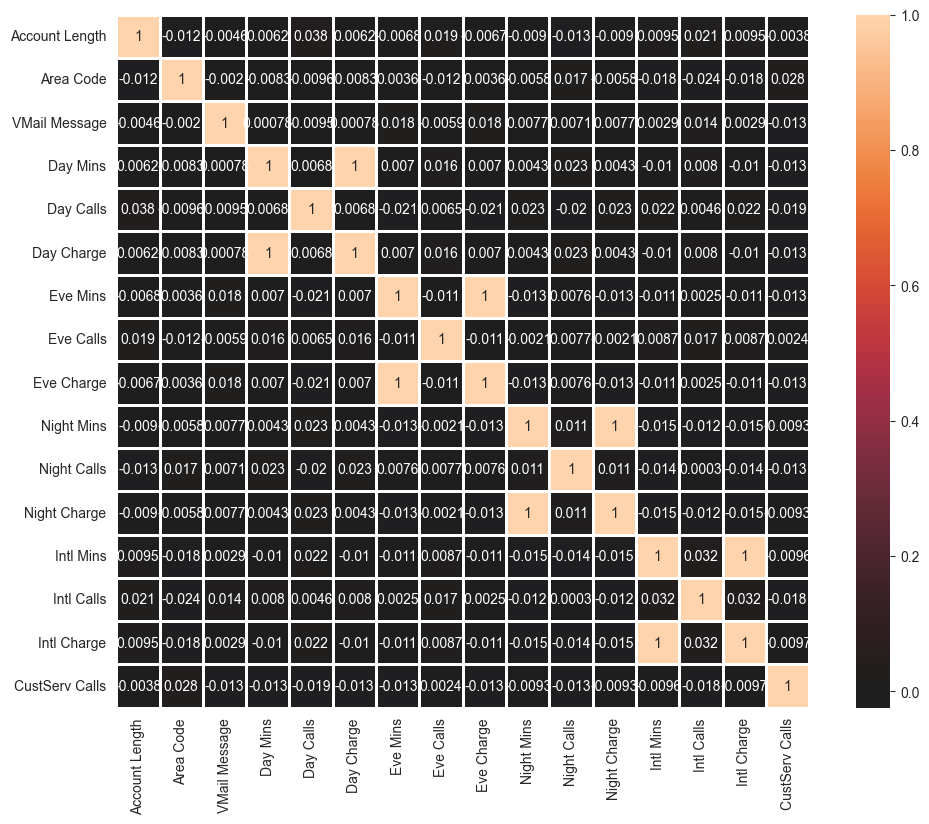

In [153]:
corr = data.corr(numeric_only=True)
sns.heatmap(corr,center=0, square=True, linewidths=.9, annot=True)

In [10]:
data.info()
drop_cols = ['Phone', 'Day Charge', 'Eve Charge', 'Night Charge','Intl Charge']
cat_cols = ['State', 'Area Code']
num_cols= ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 
                'Eve Mins', 'Eve Calls',  'Night Mins', 'Night Calls', 
                'Intl Mins', 'Intl Calls', 'CustServ Calls']
bool_cols = ['Intl Plan', 'VMail Plan']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Intl Plan       3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

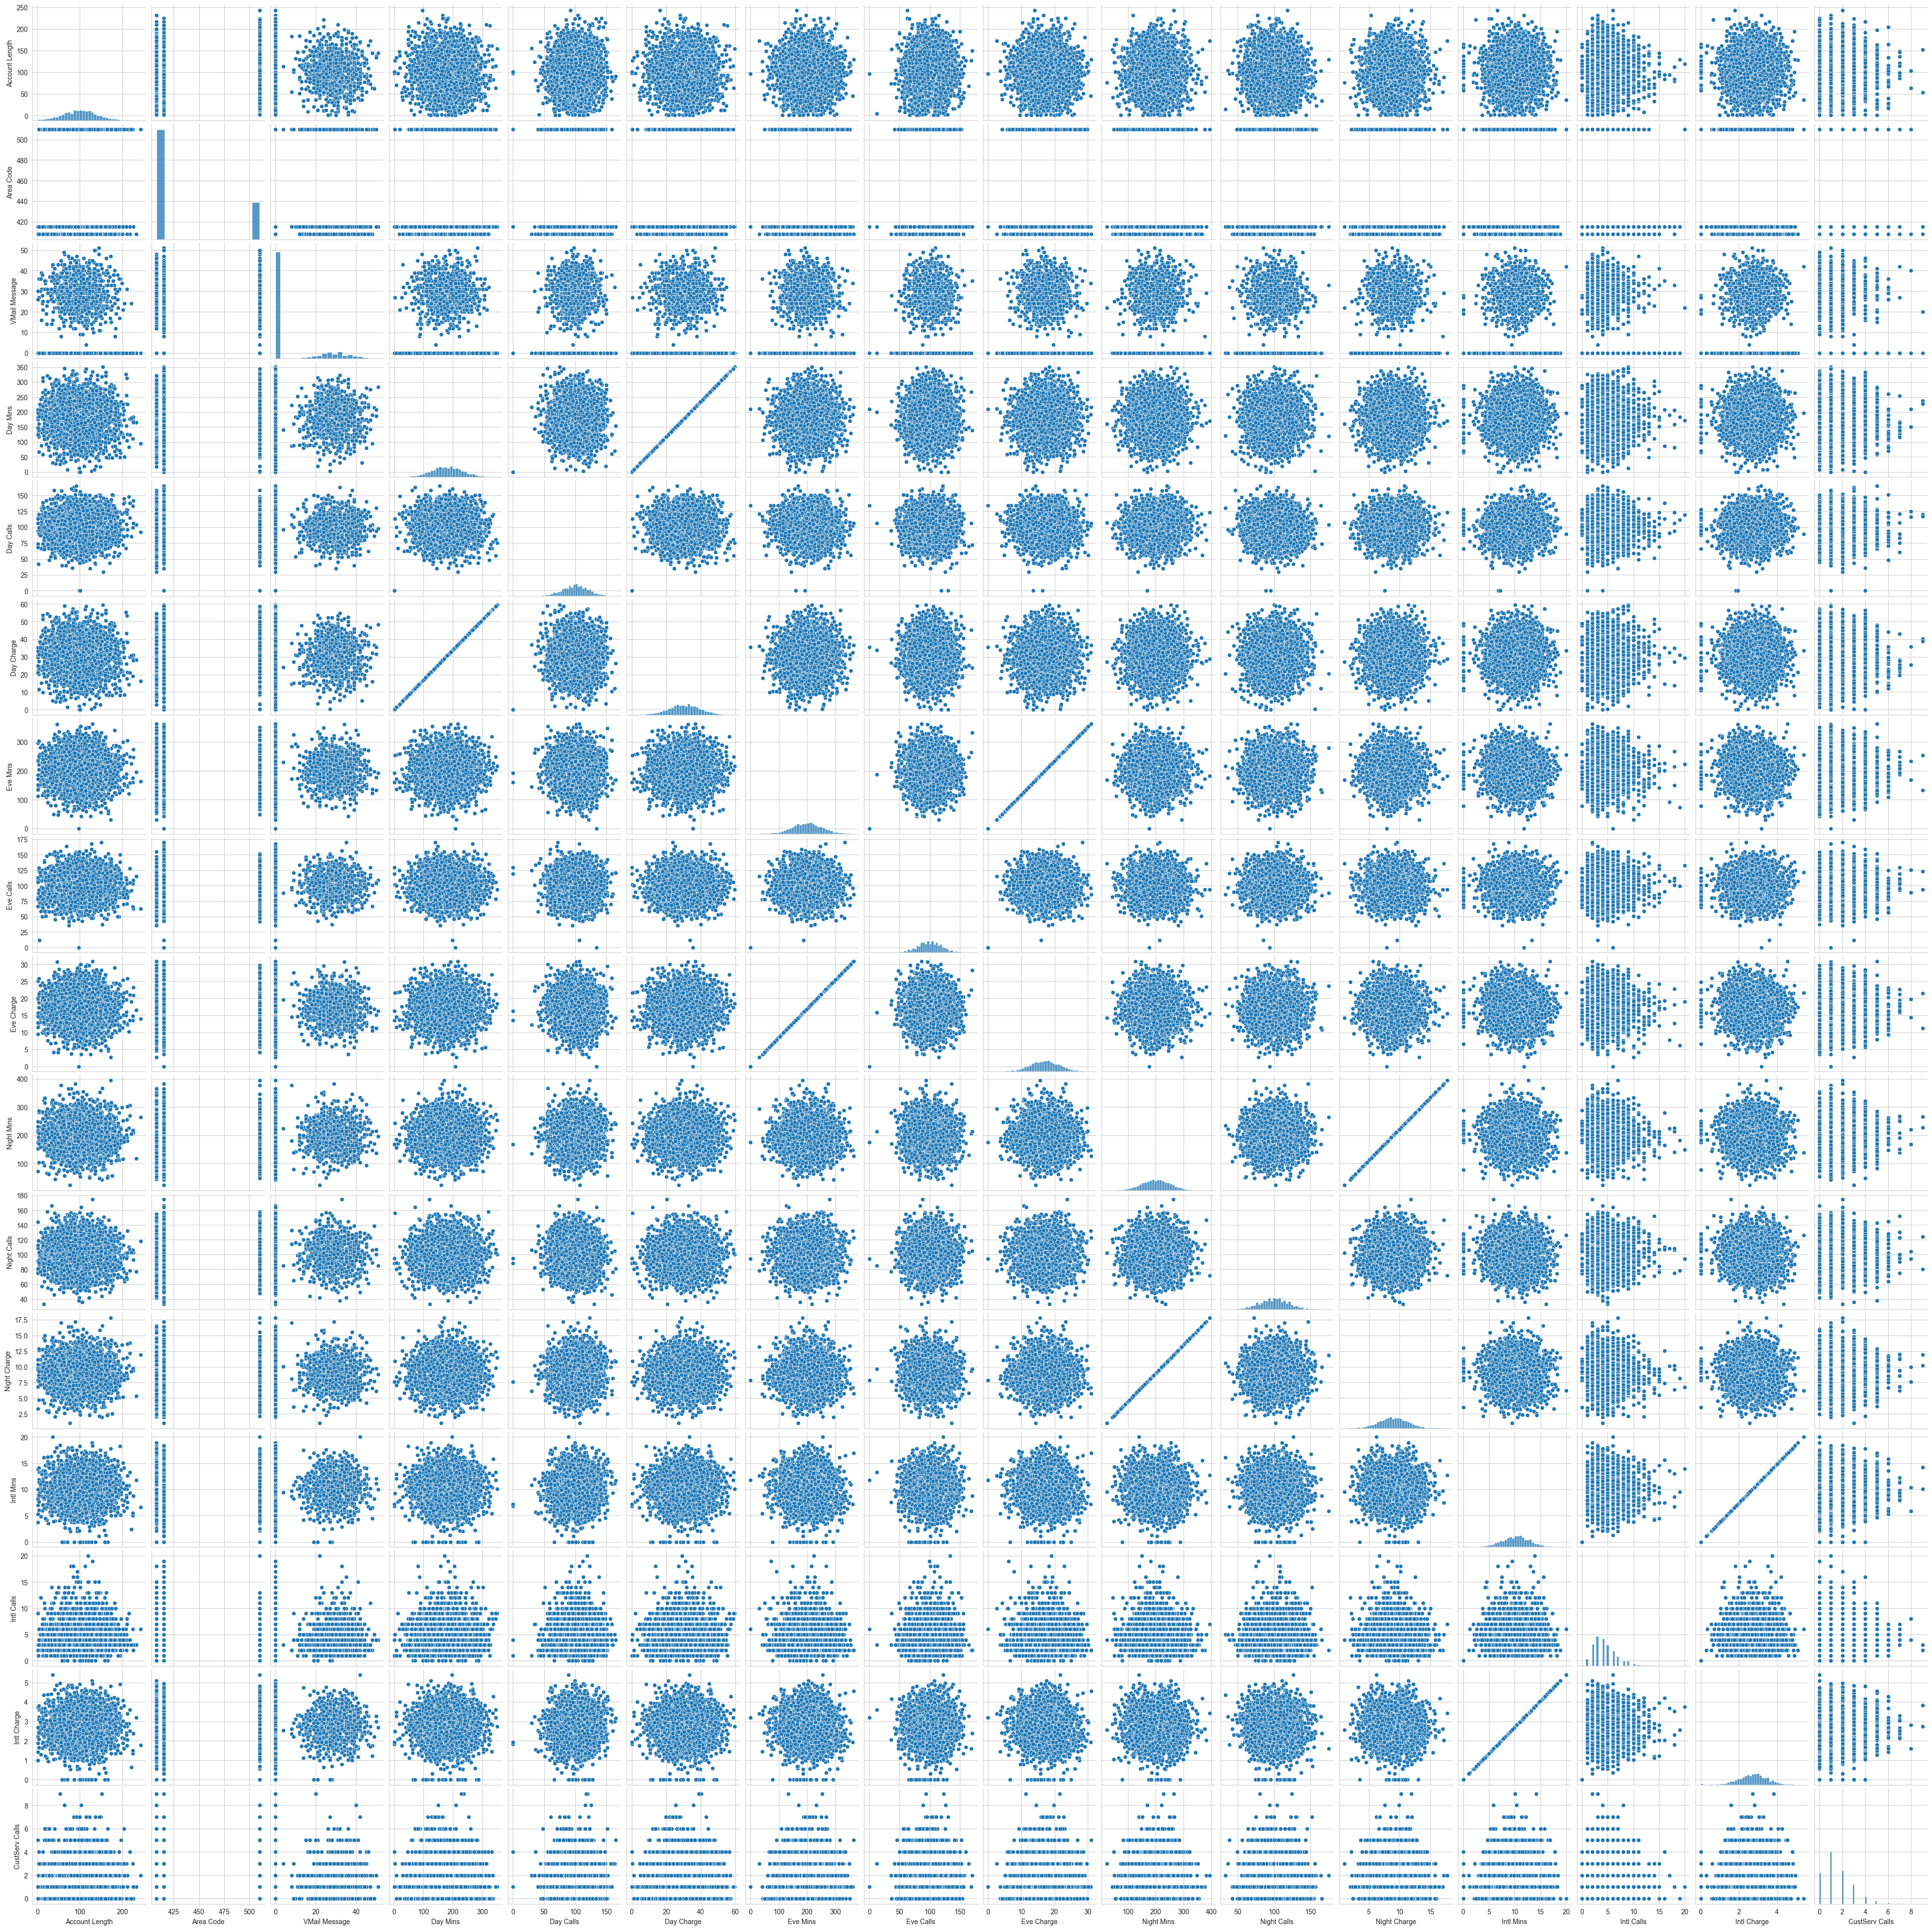

In [126]:
sns.pairplot(data)

In [11]:
data.Churn.replace({'False.': 0, 'True.': 1}, inplace=True)
for col in bool_cols:
    data[col] = data[col].replace({'no': 0, 'yes': 1})

In [12]:
data.Churn.value_counts()

Churn
0    2850
1     483
Name: count, dtype: int64

**CLasses are unbalanced**  
Let's leave final version of dataset

In [13]:
data_final = data.drop(columns=drop_cols)

In [14]:
data_final

State  Account Length  Area Code  Intl Plan  VMail Plan  VMail Message  \
0       KS             128        415          0           1             25   
1       OH             107        415          0           1             26   
2       NJ             137        415          0           0              0   
3       OH              84        408          1           0              0   
4       OK              75        415          1           0              0   
...    ...             ...        ...        ...         ...            ...   
3328    AZ             192        415          0           1             36   
3329    WV              68        415          0           0              0   
3330    RI              28        510          0           0              0   
3331    CT             184        510          1           0              0   
3332    TN              74        415          0           1             25   

      Day Mins  Day Calls  Eve Mins  Eve Calls  Night Mins  Night Calls  \
0        265.1        110     197.4         99       244.7           91   
1        161.6        123     195.5        103       254.4          103   
2        243.4        114     121.2        110       162.6          104   
3        299.4         71      61.9         88       196.9           89   
4        166.7        113     148.3        122       186.9          121   
...        ...        ...       ...        ...         ...          ...   
3328     156.2         77     215.5        126       279.1           83   
3329     231.1         57     153.4         55       191.3          123   
3330     180.8        109     288.8         58       191.9           91   
3331     213.8        105     159.6         84       139.2          137   
3332     234.4        113     265.9         82       241.4           77   

      Intl Mins  Intl Calls  CustServ Calls  Churn  
0          10.0           3               1      0  
1          13.7           3               1      0  
2          12.2           5               0      0  
3           6.6           7               2      0  
4          10.1           3               3      0  
...         ...         ...             ...    ...  
3328        9.9           6               2      0  
3329        9.6           4               3      0  
3330       14.1           6               2      0  
3331        5.0          10               2      0  
3332       13.7           4               0      0  

[3333 rows x 16 columns]

#### SImple models

In [65]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline

X, y = data_final.iloc[:, :-1], data_final.iloc[:, -1] 
prepoc = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)

In [42]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)

models = [("CAT", cat), ("XGB", xgb)]

CAT accuracy score: 0.9227272727272727
CAT f1_score: 0.6692607003891051
____________________
XGB accuracy score: 0.9263636363636364
XGB f1_score: 0.6920152091254752
____________________


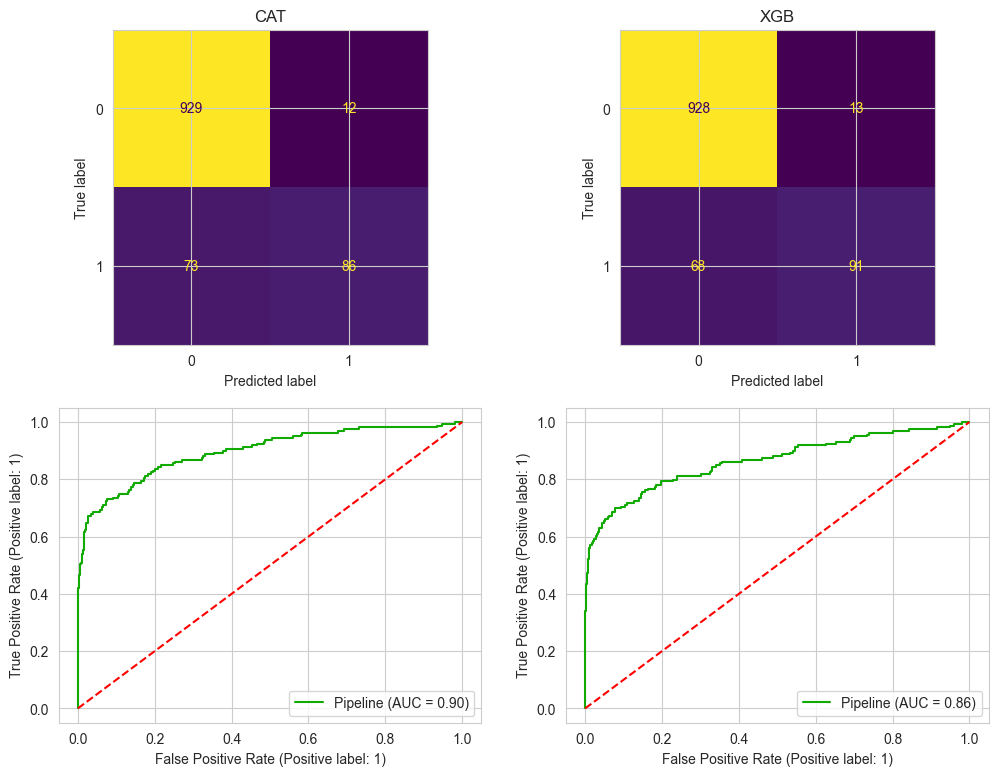

In [77]:
def calc_plot_models(models, X_train, X_test, y_train, y_test):
    fig, axes = plt.subplots(2,len(models))
    for i, (name, model) in enumerate(models):
        pipe = make_pipeline(prepoc, model)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        # y_pred_prob = pipe.predict_proba(X_test)
        print(f'{name} accuracy score: {accuracy_score(y_test, y_pred)}')
        print(f'{name} f1_score: {f1_score(y_test, y_pred)}')
        print('_'*20)
        cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
        ConfusionMatrixDisplay(cm).plot(ax=axes.flatten()[i], colorbar=False)
        axes.flatten()[i].set_title(f'{name}')
        RocCurveDisplay.from_estimator(pipe, X_test, y_test, color="#1a0", ax=axes.flatten()[i+2])
        axes.flat[i+2].plot([0, 1], 'r--')
calc_plot_models(models, X_train, X_test, y_train, y_test)      

**let's upsample underrepreented class**

CAT accuracy score: 0.9636363636363636
CAT f1_score: 0.8870056497175142
____________________
XGB accuracy score: 0.9709090909090909
XGB f1_score: 0.9085714285714286
____________________


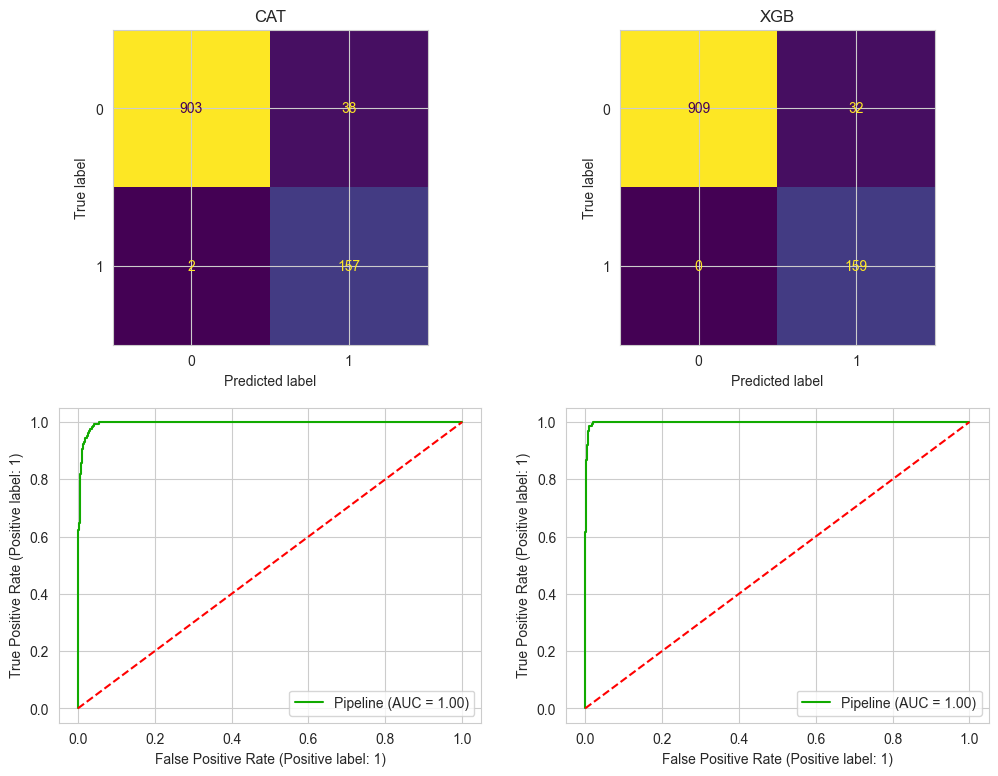

In [76]:
data_f_up = pd.concat([data_final.query('Churn==1').sample(n=2850, replace=True), data_final.query('Churn==0')])
X, y = data_f_up.iloc[:, :-1], data_f_up.iloc[:, -1] 
prepoc = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), cat_cols)
])

X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)
calc_plot_models(models, X_train_up, X_test, y_train_up, y_test)

**Wow! Looks very good! Let's optimize hypermarameters. We will proceed with XGB**

In [87]:
prepoc

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Account Length', 'VMail Message', 'Day Mins',
                                  'Day Calls', 'Eve Mins', 'Eve Calls',
                                  'Night Mins', 'Night Calls', 'Intl Mins',
                                  'Intl Calls', 'CustServ Calls']),
                                ('ohe', OneHotEncoder(),
                                 ['State', 'Area Code'])])

In [91]:
# params = {
#             'xgbrfclassifier__n_estimators': [100, 200, 300],
#             "xgbrfclassifier__learning_rate": [0.01, 0.05, 0.10, 0.5, 1.0],
#             "xgbrfclassifier__max_depth": [3, 5, 10],
#             "xgbrfclassifier__min_child_weight": [1, 3, 5]
# }

params = {
            'xgbclassifier__n_estimators': [100, 200, 300],
            "xgbclassifier__learning_rate": [0.01, 0.05, 0.10, 0.5, 1.0],
            "xgbclassifier__max_depth": [3, 5, 10],
            "xgbclassifier__min_child_weight": [1, 3, 5]
}


pipe = make_pipeline(prepoc, xgb)
grid_search = GridSearchCV(pipe, param_grid=params, scoring='roc_auc')
grid_search.fit(X_train_up, y_train_up)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['Account '
                                                                          'Length',
                                                                          'VMail '
                                                                          'Message',
                                                                          'Day '
                                                                          'Mins',
                                                                          'Day '
                                                                          'Calls',
                                                                          'Eve '
                                                                          'Mins',
                                                                          'Eve '
                                                                          'Calls',
                                                                          'Night '
                                                                          'Mins',
                                                                          'Night '
                                                                          'Calls',
                                                                          'Intl '
                                                                          'Mins',
                                                                          'Intl '
                                                                          'Calls',
                                                                          'CustServ '
                                                                          'Calls']),
                                                                        ('ohe',
                                                                         OneHotEncoder(),
                                                                         ['State',
                                                                          'Area '
                                                                          'Code'])])),
                                       ('xgbclassifier',
                                        XG...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=111, ...))]),
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.5,
                                                          1.0],
                         'xgbclassifier__max_depth': [3, 5, 10],
                         'xgbclassifier__min_child_weight': [1, 3, 5],
                         'xgbclassifier__n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [95]:
best_model = grid_search.best_estimator_

Best_model accuracy score: 0.9690909090909091
Best_model f1_score: 0.9034090909090909
____________________


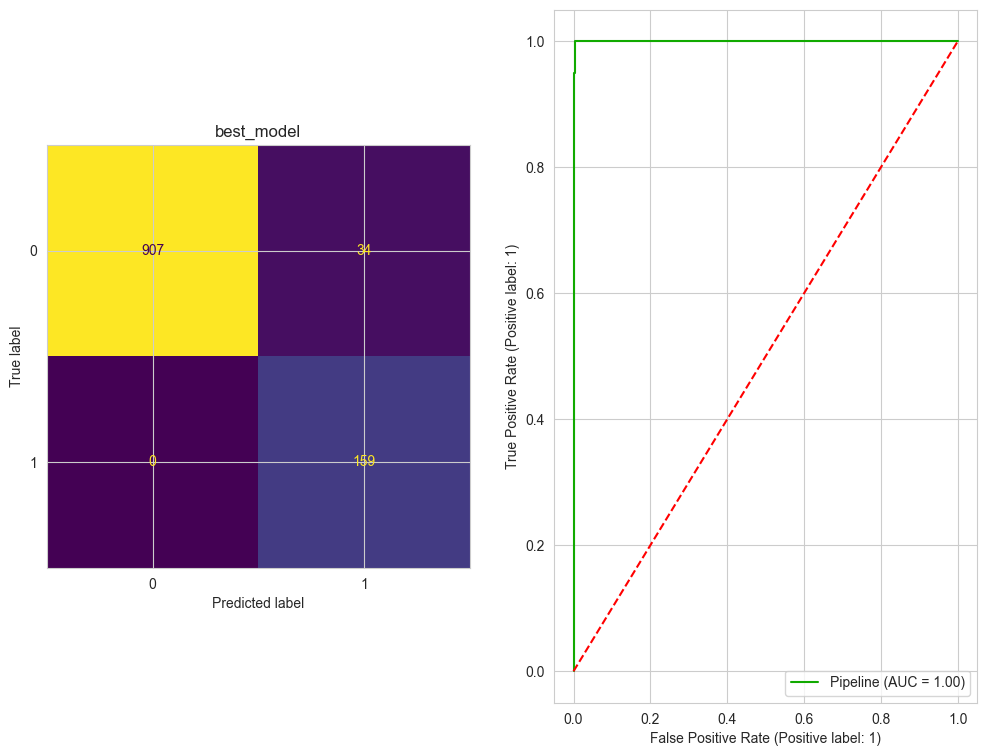

In [96]:
fig, axes = plt.subplots(1,2)

best_model.predict

y_pred = best_model.predict(X_test)
print(f'Best_model accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'Best_model f1_score: {f1_score(y_test, y_pred)}')
print('_'*20)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
ConfusionMatrixDisplay(cm).plot(ax=axes.flatten()[0], colorbar=False)
axes.flatten()[0].set_title(f'best_model')
RocCurveDisplay.from_estimator(best_model, X_test, y_test, color="#1a0", ax=axes.flatten()[1])
axes.flat[1].plot([0, 1], 'r--')



**Well, it became even a little worser. I believe, deafault params were mire optimal and finding even better alternative would reqire much bbigger parameter grid with finer resolution**